# Packages and Functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

pd.set_option('display.max_columns', None)

In [4]:
def adjust_data_types(df):
    for col in df.columns:
        unique_vals = df[col].unique()
        if df[col].dtypes == 'object':
            None
#         elif (set(unique_vals) == {0, 1}) or col == 'userId':
#             df[col] = df[col].astype('int64')
#         else:
#             df[col] = df[col].astype('float64')
        elif (set(unique_vals) != {0, 1}):
            df[col] = df[col].astype('float64')
        else:
            df[col] = df[col].astype('int64')
    return df

In [5]:
# ho_t02['userId'] = ho_t02['userId'].astype('str')
# ho_t02 = adjust_data_types(ho_t02)
# ho_t02.info()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.feature_selection import RFE, RFECV, VarianceThreshold

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, permutation_test_score
from sklearn.base import clone


from imblearn.metrics import geometric_mean_score
import shap

from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline
# from sklearn.pipeline import Pipeline

import dice_ml

from catboost import CatBoostClassifier

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.


In [109]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

specificity_scorer = make_scorer(specificity_score)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    npv = tn / (tn + fn)
    return npv

npv_scorer = make_scorer(npv_score)

g_mean_scorer = make_scorer(geometric_mean_score)


skf = StratifiedKFold(10, shuffle=True, random_state=0)

# def get_cat_cols(df):
#     one_hot_encoded_columns = []

#     for idx, column in enumerate(df.columns):
#         if df[column].nunique() == 2 and set(df[column].unique()) == {0, 1}:
#             one_hot_encoded_columns.append(idx)

#     return one_hot_encoded_columns

def get_cat_cols(df):
    return df.select_dtypes(include=['object']).columns.tolist()

# get_cat_cols(ho_t02)
# cat_cols = get_cat_cols(ho_t02)
# num_cols = [col for col in ho_t02.columns if col not in cat_cols]
# cat_cols, num_cols

def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)

In [112]:
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek


from sklearn.base import BaseEstimator, TransformerMixin

class DropCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Assuming X is a DataFrame
        non_categorical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
        return X[non_categorical_cols]


def knn_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', KNeighborsClassifier())
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
#             SMOTEENN(random_state=random_state),
#             SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
#             TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)
        ],
        'classifier__n_neighbors': list(range(1, 16)),
        'classifier__metric': ['euclidean', 'cosine', 'hamming', 'braycurtis',
                               'chebyshev', 'canberra', 'cityblock', 'sqeuclidean'
                              ]
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def svm_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', SVC(random_state=random_state, max_iter=1000,
                           verbose=True))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#         ],
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
        'classifier__C': list(np.logspace(-6, 6, num=13)),
        'classifier__probability': [True, False],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def logreg_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
#         ('drop_categorical', None),
#         ('encoder', None),
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', LogisticRegression(random_state=random_state, max_iter=1000))
    ])

    param_grid = {
#         'drop_categorical': [None, DropCategoricalFeatures()]
#         'encoder': [None, OneHotEncoder(sparse_output=False)],
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
        'classifier__C': list(np.logspace(-6, 6, num=13)),
        'classifier__penalty': ['l2', None],
        'classifier__solver': ['liblinear', 'lbfgs', 'newton-cholesky']
#         'classifier__penalty': ['l1', l2', 'elasticnet', 'None']
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    train_score = best_estimator.score(X_train, y_train)
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    # print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    # print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    print('Train Score of Best Model:', train_score)
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    y_train_pred = best_estimator.predict_proba(X_train)[:, 1]
    efron = efron_rsquare(y_train, y_train_pred)
    print('Efron R-squared:', efron)


    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'train_score': train_score,
        'efron': efron,
        # 'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df



def dt_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    cat_cols = get_cat_cols(X_train)
    num_cols = [col for col in X_train.columns if col not in cat_cols]


    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(), 
#             RobustScaler(),
#             MinMaxScaler()
#         ],
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
            SMOTEENN(random_state=random_state),
            SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
            TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)
        ],
#         'classifier__max_depth': [3],
# #         'classifier__min_samples_split': [1],
#         'classifier__min_samples_leaf': [1],
#         'classifier__max_depth': [2, 5],
#         'classifier__min_samples_split': [3],
#         'classifier__min_samples_leaf': [3],
# #         'classifier__max_features': ['auto', 'sqrt', 'log2', None],
#         'classifier__criterion': ["entropy", "log_loss"]
#         'classifier__max_depth': [2, 3],
#         'classifier__min_samples_split': [1],
#         'classifier__min_samples_leaf': [2, 3],
        'classifier__max_depth': [2, 3, 5],
        'classifier__min_samples_split': [2, 3],
        'classifier__min_samples_leaf': [1, 2, 3],
        'classifier__max_features': ['auto', 'sqrt', 'log2', None],
        'classifier__criterion': ["gini", "entropy", "log_loss"]
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
#                                cv=10, scoring=scorer,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

from sklearn.decomposition import TruncatedSVD

def rf_class2(df, scorer, label_col, scaler, random_state=0):
#     df_majority = df[df.home_ownership_class == 0]
#     df_minority = df[df.home_ownership_class == 1]

# #     display(df_majority)
# #     display(df_minority)
# #     print(len(df_majority), len(df_minority))
#     # Randomly downsample majority class
#     df_majority_downsampled = df_majority.sample(frac=0.2,
#                                                  random_state=random_state)
#     df = pd.concat([df_majority_downsampled, df_minority], axis=0)

    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)

#     n_components = X_scaled.shape[1]  # Maximum number of components
#     svd = TruncatedSVD(n_components=n_components)
#     X_svd = svd.fit_transform(X_scaled)

#     # Step 3: Find number of components that explain at least 90% variance
#     cum_variance = np.cumsum(svd.explained_variance_ratio_)
#     num_components = np.argmax(cum_variance >= 0.90) + 1  # +1 because Python indexing starts from 0
#     X_selected = X_svd[:, :num_components]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

#     X_resampled, y_resampled = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)
#     class_counts_original = np.bincount(y_train.astype(int))
#     class_counts_resampled = np.bincount(y_resampled.astype(int))

    # Assuming 0 is the majority class, calculate its upweight factor
#     majority_class_original = class_counts_original[0]
#     majority_class_resampled = class_counts_resampled[0]
#     upweight_factor = majority_class_original / majority_class_resampled

#     minority_class_original = class_counts_original[1]
#     minority_class_resampled = class_counts_resampled[1]
#     downweight_factor = minority_class_original / minority_class_resampled

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', RandomForestClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
#             SMOTEENN(random_state=random_state),
#             SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
#             TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)
        ],
        'classifier__n_estimators': [200, 300],
        'classifier__max_depth': [2, 3],
        'classifier__min_samples_split': [2, 3],
        'classifier__min_samples_leaf': [2, 3],
        'classifier__oob_score': [True, False],
        'classifier__criterion': ["gini", "entropy", "log_loss"]

#         'classifier__n_estimators': [200, 250],
#         'classifier__max_depth': [2, 3],
#         'classifier__min_samples_split': [3, 4],
#         'classifier__min_samples_leaf': [3, 4],
#         'classifier__oob_score': [True, False],
#         'classifier__criterion': ["gini", "entropy", "log_loss"]
    }
#         'classifier__n_estimators': [200, 250, 300],
# #         'classifier__max_depth': [2, 3, 4],
#         'classifier__max_depth': [2],
#         'classifier__class_weight': [{0: 263/807, 1:1}],
#         'classifier__oob_score': [True],
# #         'classifier__class_weight': [{0: 1, 1:807/263}],
#         'classifier__min_samples_split': [3, 4],
#         'classifier__min_samples_leaf': [3, 4],
#         'classifier__criterion': ["gini", "entropy", "log_loss"]
#     }
    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
#                                cv=10, scoring=scorer,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def gbm_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', GradientBoostingClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
        'resampling': [
            SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
#         'classifier__n_estimators': [200],
#         'classifier__max_depth': [None],
#         'classifier__min_samples_leaf': [3],
#         'classifier__min_samples_split': [5],
#         'classifier__learning_rate': [0.1]
        'classifier__n_estimators': [200, 250],
        'classifier__max_depth': [2, 3],
        'classifier__min_samples_leaf': [2, 3],
        'classifier__min_samples_split': [2, 3],
        'classifier__learning_rate': [0.1]
    }
#         'loss': ['log_loss', 'deviance', 'exponential']
#         'min_samples_leaf': [1, 2, 3],
#         'min_samples_split': [2, 3, 5],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def lgbm_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, len(explained_var_ratio)+1), cumulative_explained_var, marker='o', linestyle='--')
#     plt.title('Cumulative Explained Variance Plot')
#     plt.xlabel('Number of Components')
#     plt.ylabel('Cumulative Explained Variance')
#     plt.grid(True)
#     plt.show()

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', LGBMClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
#         'classifier__n_estimators': [400, 450],
#         'classifier__learning_rate': [0.01],
#         'classifier__num_leaves': [20, 25],
#         'classifier__min_child_samples': [40, 45],
#         'classifier__class_weight': [{0: 263/807, 1:1}, {0: 1, 1:807/263}],
#         'classifier__class_weight': [{0: 1, 1:807/263}],
#         'classifier__max_depth': [2, 3],
#         'classifier__boosting_type': ['gbdt', 'dart', 'goss']

        'classifier__n_estimators': [200, 300, 400],
        'classifier__learning_rate': [0.1, 0.01],
#         'classifier__num_leaves': [20, 25],
#         'classifier__min_child_samples': [40, 45],
#         'classifier__class_weight': [{0: 263/807, 1:1}, {0: 1, 1:807/263}],
#         'classifier__class_weight': [{0: 1, 1:807/263}],
        'classifier__max_depth': [2, 3],
        'classifier__boosting_type': ['gbdt', 'dart', 'goss']
    }
#         'classifier__num_leaves': [20, 31, 40],
#         'classifier__min_child_samples': [10, 20, 30],
#         'classifier__max_depth': [-1, 5, 10],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def xgb_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', XGBClassifier(random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
#         'resampling': [SMOTE(random_state=random_state),
#                        SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
#                        ADASYN(random_state=random_state),
# #                        RandomOverSampler(random_state=random_state),
#                        RandomUnderSampler(random_state=random_state)],
#         'scaler': [RobustScaler(),
#                    PowerTransformer()],
#         'resampling': [SMOTENC(categorical_features=get_cat_cols(X),
#                                random_state=random_state),
        'resampling': [SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
# #         'classifier__n_estimators': [200, 250],
#         'classifier__learning_rate': [2, 3],
# #         'classifier__max_depth': [2, 3],
#         'classifier__max_leaves': [5],
#         'classifier__grow_policy': ['depthwise', 'lossguide']
        'classifier__n_estimators': [200, 250],
        'classifier__learning_rate': [0.01, 0.1, 1],
        'classifier__max_depth': [None, 2, 3],
        'classifier__max_leaves': [10, 20, 30],
        'classifier__grow_policy': ['depthwise', 'lossguide']
    }
#         'classifier__max_depth': [None, 5, 10],
#         'classifier__max_leaves': [0, 10, 20],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def adaboost_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    cat_cols = get_cat_cols(X_train)
    num_cols = [col for col in X_train.columns if col not in cat_cols]

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', AdaBoostClassifier(
            random_state=random_state))
    ])

    param_grid = {
#         'scaler': [
#             StandardScaler(),
#             MinMaxScaler(),
#             RobustScaler()
#         ],
        'resampling': [
            SMOTE(random_state=random_state),
            ADASYN(random_state=random_state),
#             SMOTEENN(random_state=random_state),
#             SMOTETomek(random_state=random_state),
            EditedNearestNeighbours(),
#             TomekLinks(),
            RandomOverSampler(random_state=random_state),
            RandomUnderSampler(random_state=random_state)],
        'classifier__n_estimators': [200, 300],
        'classifier__estimator': [DecisionTreeClassifier(
            random_state=random_state,
#             criterion='entropy', max_depth=3,
#             min_samples_leaf=2, min_samples_split=2
        ),
                                  RandomForestClassifier(
            random_state=random_state,
#             max_depth=3, min_samples_leaf=2,
#             min_samples_split=2, n_estimators=250,
#             oob_score=True
                                                        )],
#         'classifier__learning_rate': [0.01, 0.1, 1],
        'classifier__algorithm': ['SAMME', 'SAMME.R']
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

from sklearn.linear_model import RidgeClassifier

def ridge_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

#     scaler = RobustScaler()
#     X_scaled = scaler.fit_transform(X)
#     pca = PCA().fit(X_scaled)

#     # 2. Plot the cumulative explained variance
#     explained_var_ratio = pca.explained_variance_ratio_
#     cumulative_explained_var = np.cumsum(explained_var_ratio)

#     # 3. Find the number of components that explain up to 90% of the variance
#     num_components = np.argmax(cumulative_explained_var >= 0.90) + 1
#     print(f"Number of components that explain up to 90% of variance: {num_components}")

#     # Refit PCA with the selected number of components
#     pca_90 = PCA(n_components=num_components)
#     X = pca_90.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    cat_cols = get_cat_cols(X_train)
    num_cols = [col for col in X_train.columns if col not in cat_cols]
    
    cat_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    num_transformer = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.15))
    ])
    
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ],
        remainder='passthrough'
    )

    preprocessor_num = ColumnTransformer(
        transformers = [
            ('num', num_transformer, num_cols)
        ],
        remainder='drop'
    )

    preprocessor_drop_cat = ColumnTransformer(
        transformers = [
            ('num', 'passthrough', num_cols)
        ],
        remainder='drop'
    )

    pipeline = Pipeline([
#         ('preprocessor', None),
        ('preprocessor', preprocessor_drop_cat),
        ('scaler', scaler),
        ('resampling', None),
        ('var_threshold', VarianceThreshold(threshold=0.15)),
        ('classifier', RidgeClassifier(max_iter=1000, random_state=random_state))
    ])

    param_grid = {
#         'preprocessor': [
#             preprocessor_drop_cat,
#             preprocessor,
#             preprocessor_num            
#         ],
        'resampling': [ADASYN(random_state=random_state),
                       SMOTEENN(random_state=random_state),
                       SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
                       TomekLinks(),
                       RandomUnderSampler(random_state=random_state)],
        'classifier__alpha': [0.01, 0.1, 1, 10, 100, 1000],
        'classifier__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga'],
    }

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=10, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

def catboost_class2(df, scorer, label_col, scaler, random_state=0):
    X = df.drop(['userId', 'lastFirstName', label_col], axis=1)
    y = df.loc[:, label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y,
                                                        random_state=random_state)

    pipeline = Pipeline([
        ('scaler', scaler),
        ('resampling', None),
        ('classifier', CatBoostClassifier(random_state=random_state, ))
    ])

    param_grid = {
#         'scaler': [StandardScaler(),
#                    MinMaxScaler(),
#                    RobustScaler()
#                   ],
        'resampling': [
            SMOTE(random_state=random_state),
                       ADASYN(random_state=random_state),
#                        SMOTEENN(random_state=random_state),
#                        SMOTETomek(random_state=random_state),
                       EditedNearestNeighbours(),
#                        TomekLinks(),
                       RandomOverSampler(random_state=random_state),
                       RandomUnderSampler(random_state=random_state)],
#         'classifier__n_estimators': [200],
#         'classifier__max_depth': [None],
#         'classifier__min_samples_leaf': [3],
#         'classifier__min_samples_split': [5],
#         'classifier__learning_rate': [0.1]
#         'classifier__n_estimators': [200, 250],
#         'classifier__max_depth': [2, 3],
#         'classifier__min_samples_leaf': [2, 3],
#         'classifier__min_samples_split': [2, 3],
#         'classifier__learning_rate': [0.1]
    }
#         'loss': ['log_loss', 'deviance', 'exponential']
#         'min_samples_leaf': [1, 2, 3],
#         'min_samples_split': [2, 3, 5],

    start_time_cv = time.time()
    grid_search = GridSearchCV(pipeline, param_grid,
                               cv=skf, scoring=scorer,
                               n_jobs=-1,
                               verbose=4, return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    end_time_cv = time.time()

    print("Best Hyperparameters:", best_params)
    print("Best Validation Score (Precision):", best_score)
    print('Best Estimator:', best_estimator)
    print('Mean Train Score (Precision)', np.mean(cv_results['mean_train_score']))
    print('Std Train Score (Precision)', np.mean(cv_results['std_train_score']))
    elapsed_time_cv = (end_time_cv - start_time_cv)
    print(f'GridSearchCV Runtime: {elapsed_time_cv} secs')

    num_runs = 5
    metrics_per_run = []

    for run in range(num_runs):
        modified_random_state = random_state + run

        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25,
                                                            stratify=y,
                                                            random_state=modified_random_state)

        modified_estimator = clone(best_estimator)
#         if not (isinstance(best_estimator.named_steps['resampling'], EditedNearestNeighbours) or
#             isinstance(best_estimator.named_steps['resampling'], TomekLinks)):
#             modified_estimator.named_steps['resampling'].set_params(random_state=modified_random_state)
#         modified_estimator.named_steps['classifier'].set_params(random_state=modified_random_state)
        modified_estimator.fit(X_train, y_train)

        y_pred = modified_estimator.predict(X_test)

        end_time = time.time()
        elapsed_time = (end_time - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        npv = npv_score(y_test, y_pred)
        g_mean = geometric_mean_score(y_test, y_pred)

        print(f"Run {run + 1} - Random State: {modified_random_state}")
        print(f"Test Precision: {precision}")

#         y_hat = modified_estimator.predict_proba(X_test)[:, 1]

#         fpr, tpr, thresholds = roc_curve(y_test, y_hat)
#         gmeans = np.sqrt(tpr * (1-fpr))
#         ix = np.argmax(gmeans)
#         print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#         plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#         plt.plot(fpr, tpr, marker='.', label='Original')
#         plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.legend()

#         plt.show()

        metrics_per_run.append({
            'Random State': modified_random_state,
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1 Score': f1,
            'Test Specificity': specificity,
            'Test G-mean': g_mean,
            'Test NPV': npv,
            'Runtime': elapsed_time
        })

    metrics_df = pd.DataFrame(metrics_per_run)

    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print('Ave Test Precision:', avg_metrics['Test Precision'])
    print('Stdev Test Precision:', std_metrics['Test Precision'])
    print("Ave Test Accuracy:", avg_metrics['Test Accuracy'])
    print('Stdev Test Accuracy:', std_metrics['Test Accuracy'])
    print("Ave Test Specificity:", avg_metrics['Test Specificity'])
    print("Ave Test Recall:", avg_metrics['Test Recall'])
    print('Ave Test NPV:', avg_metrics['Test NPV'])
    print("Ave Test F1-Score:", avg_metrics['Test F1 Score'])
    print("Ave Test G-mean:", avg_metrics['Test G-mean'])
    print("Ave Runtime:", avg_metrics['Runtime'])

    model_info = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'mean_train_score': np.mean(cv_results['mean_train_score']),
        'std_train_score': np.mean(cv_results['std_train_score']),
        'average_test_precision': avg_metrics['Test Precision'],
        'stdev_test_precision': std_metrics['Test Precision'],
        'average_test_accuracy': avg_metrics['Test Accuracy'],
        'stdev_test_accuracy': std_metrics['Test Accuracy'],
        'average_runtime': avg_metrics['Runtime'],
        'average_test_specificity': avg_metrics['Test Specificity'],
        'average_test_recall': avg_metrics['Test Recall'],
        'average_test_npv': avg_metrics['Test NPV'],
        'average_test_f1_score': avg_metrics['Test F1 Score'],
        'average_test_g_mean': avg_metrics['Test G-mean']
    }

    return grid_search, best_estimator, model_info, metrics_df

In [ ]:
help(CatBoostClassifier)
CatBoostClassifier()

Help on class CatBoostClassifier in module catboost.core:

class CatBoostClassifier(CatBoost)
 |  CatBoostClassifier(iterations=None, learning_rate=None, depth=None, l2_leaf_reg=None, model_size_reg=None, rsm=None, loss_function=None, border_count=None, feature_border_type=None, per_float_feature_quantization=None, input_borders=None, output_borders=None, fold_permutation_block=None, od_pval=None, od_wait=None, od_type=None, nan_mode=None, counter_calc_method=None, leaf_estimation_iterations=None, leaf_estimation_method=None, thread_count=None, random_seed=None, use_best_model=None, best_model_min_trees=None, verbose=None, silent=None, logging_level=None, metric_period=None, ctr_leaf_count_limit=None, store_all_simple_ctr=None, max_ctr_complexity=None, has_time=None, allow_const_label=None, target_border=None, classes_count=None, class_weights=None, auto_class_weights=None, class_names=None, one_hot_max_size=None, random_strength=None, random_score_type=None, name=None, ignored_feature

## Outlier Analysis Functions

In [9]:
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

def plot_hist_ee(df, bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = EllipticEnvelope(random_state=0)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel('Elliptic Envelope scores')
    plt.ylabel('Frequency')
    plt.title(f'Elliptic Envelope score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_ee(df, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'Elliptic Envelope, Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

def plot_hist_gmm(df, n_components, covariance_type='full', bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = GaussianMixture(n_components=n_components,
                            covariance_type=covariance_type,
                            random_state=0)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{n_components}-component Gaussian Mixture Model scores')
    plt.ylabel('Frequency')
    plt.title(f'{n_components}-component Gaussian Mixture Model score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_gmm(df, n_components, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{n_components}-component Gaussian Mixture Model, Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

def plot_hist_lof(df, n_neighbors=20, bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = LocalOutlierFactor(n_neighbors=n_neighbors)
    model.fit(scaled_data)
    
#     model_scores = model.score_samples(scaled_data)
    model_scores = model.negative_outlier_factor_
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{n_neighbors}-neighbor Local Outlier Factor (LOF) scores')
    plt.ylabel('Frequency')
    plt.title(f'{n_neighbors}-neighbor Local Outlier Factor (LOF) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_lof(df, n_neighbors, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{n_neighbors}-neighbor Local Outlier Factor (LOF), Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

def plot_hist_ocsvm(df, kernel='rbf', bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = OneClassSVM(kernel=kernel, degree=4)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{kernel}-kernel One-Class SVM (OCSVM) scores')
    plt.ylabel('Frequency')
    plt.title(f'{kernel}-kernel One-Class SVM (OCSVM) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_hist_ocsvm2(df, kernel='rbf', bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'ageing_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = OneClassSVM(kernel=kernel, degree=4)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{kernel}-kernel One-Class SVM (OCSVM) scores')
    plt.ylabel('Frequency')
    plt.title(f'{kernel}-kernel One-Class SVM (OCSVM) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_ocsvm(df, kernel, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{kernel}-kernel One-Class SVM (OCSVM), Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

    return list(df2[df2['pred_outlier'] == True].index)

def plot_hist_if(df, n_estimators=100, bins=1_000, xlim=None):
    df_X = df.copy().drop(['userId', 'lastFirstName', 'home_ownership_class'], axis=1)
    df_names = df.copy()[['userId', 'lastFirstName']]
    n_samples = df.shape[0]
    
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(df_X)
    scaled_data = df_X

    model = IsolationForest(n_estimators=n_estimators, random_state=0)
    model.fit(scaled_data)
    
    model_scores = model.score_samples(scaled_data)
    
    plt.hist(model_scores, bins=bins)
    plt.xlabel(f'{n_estimators}-estimator Isolation Forest (IF) scores')
    plt.ylabel('Frequency')
    plt.title(f'{n_estimators}-estimator Isolation Forest (IF) score histogram')
    if xlim is not None:
        plt.xlim(xlim, 0)
    plt.show()

    return model_scores

def plot_if(df, n_estimators, scores, threshold):
    model_scores = scores

    outlier_mask = model_scores < threshold
    plt.scatter(df.iloc[outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='purple',
                label='Predicted Outliers')
    plt.scatter(df.iloc[~outlier_mask, df.columns.get_loc('basicMonthlySalary')],
                df.iloc[~outlier_mask, df.columns.get_loc('monthlyFamilyIncome')], c='yellow',
                label='Predicted Inliers')
    plt.xlabel('Basic Monthly Salary')
    plt.ylabel('Monthly Family Income')
    plt.title(f'{n_estimators}-estimator Isolation Forest (IF), Threshold = {threshold}')
    plt.legend()
    plt.show()

    df2 = df.copy()
    df2['pred_outlier'] = (model_scores.reshape(-1, 1) < threshold)

    print('Number of predicted outliers:',
          df2[df2['pred_outlier'] == True].shape[0])
    display(df2[df2['pred_outlier'] == True])

    return list(df2[df2['pred_outlier'] == True].index)

# Loading and Preprocessing the Dataset

In [40]:
# Loading the dataset
dataset = pd.read_csv('data/df_merged_no_nans.csv')
# dataset = dataset.drop('Unnamed: 0', axis=1)

# Creating 'daysFromDateEntryStart'
# dataset['dateEntry'] = pd.to_datetime(dataset['dateEntry'], format='%Y-%m-%d')
# dateEntryStart = pd.to_datetime('2022-03-28', format='%Y-%m-%d')
# dataset['daysFromDateEntryStart'] = (dataset['dateEntry'] - dateEntryStart).dt.days

# Dropping irrelevant columns
cols_to_drop = [
    'id', 'fullName', 'firstName', 'lastName', 'address', 'occupation', 'dateEntry'
]
dataset = dataset.drop(cols_to_drop, axis=1)

boolean_columns = [col for col in dataset.columns if dataset[col].dtype == bool]
dataset[boolean_columns] = dataset[boolean_columns].apply(lambda x: x.astype('int'))

columns_to_move = ['lastFirstName', 'age', 'gender', 'province', 'job']
columns_remaining = [col for col in dataset.columns if col not in columns_to_move]

new_column_order = columns_to_move + columns_remaining
dataset = dataset[new_column_order]
dataset.insert(0, 'userId', dataset.pop('userId'))

def map_ageing_class(row):
    found_in_hdmf = row['foundInHDMF']
    home_ownership_class = row['home_ownership_class']

    if home_ownership_class == 0:
        return np.nan
    elif found_in_hdmf in [' Current', 'FP', '01 mos', '02 mos', '03 mos']:
        return 0
    elif found_in_hdmf in ['04 mos', '05 mos']:
        return 1

# One-hot encoding of categorical columns
# dataset = pd.get_dummies(dataset, columns=['gender'], prefix='gender', drop_first='True')
# dataset = pd.get_dummies(dataset, columns=['province'], prefix='province')
# dataset = pd.get_dummies(dataset, columns=['job'], prefix='job')

dataset['home_ownership_class'] = ((dataset['foundInOS'] != 'False') |
                                   (dataset['foundInHDMF'] != 'False')).astype('int')

# dataset['ageing_class'] = dataset['home_ownership_class'].astype('int64')
# dataset['ageing_class'] = dataset.apply(map_ageing_class, axis=1)

cols_to_drop = ['foundInOS', 'foundInHDMF']
dataset = dataset.drop(cols_to_drop, axis=1)

# Selecting only Cluster 1 from the dataset
# dataset = dataset[dataset['cluster'] == 1].drop(columns=['cluster'])
dataset

,userId,lastFirstName,age,gender,province,job,basicMonthlySalary,preferredNetDisposableIncomeId,workingFamilyCount,residentsCount,monthlyFamilyIncome,food,hygiene,houseCleaning,fare,parking,gasoline,tuition,allowance,uniform,otherEducation,emergency,medicine,water,electricity,rent,repair,cinema,dineOut,leisure,personalCare,clothing,mobileLoad,internet,vehicleLoan,informalLenders,companyLoan,privateLoans,governmentLoans,smoking,alcohol,gambling,smallLottery,otherVices,savings,loanOthers,payInsurance,loanSSS,payFamilySupport,loanPagIbig,loanGSIS,loanPersonal,houseHasPensioner,houseHasPrivateEmployee,houseHasBusiness,houseHasFreelancer,houseHasGovtEmployee,houseHasOFW,houseOnlyFamily,houseExtendedFamily,home_ownership_class
0,370,"IBALI, HOWARD",24,MALE,METRO MANILA,SERVICE AND SALES,19000,2,3,3,40000.0,1000,500,200,200,0,0,0,50,0,0,500,450,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,2000,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1
1,1025,"PATALINGHOG, KIMBERLY",26,FEMALE,METRO MANILA,SERVICE AND SALES,15000,3,2,4,30000.0,5000,3000,2000,2000,0,0,0,0,0,0,2000,0,200,200,1000,500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0
2,1105,"TEMILLOSO, DENNIS",40,MALE,METRO MANILA,SERVICE AND SALES,20000,2,0,3,30000.0,3000,500,300,200,50,50,500,100,100,50,500,100,200,500,0,200,0,100,100,100,200,200,200,0,0,0,0,0,0,0,0,0,0,1000,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,1719,"OSCARES, ELMER",32,MALE,UNKNOWN,MACHINE OPERATOR,21200,2,0,5,12000.0,2000,500,200,392,0,0,0,0,0,0,100,0,200,200,3000,0,0,0,0,100,200,400,0,0,0,0,0,876,0,0,0,0,0,500,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
4,2081,"LEGASPI, MANNY",39,MALE,METRO MANILA,CLERICAL SUPPORT,19800,2,0,0,25000.0,5000,2000,1000,1500,0,0,1000,500,1500,0,0,1000,300,1900,0,1000,0,1000,1000,1500,1500,500,1600,0,0,0,0,0,0,0,0,0,0,10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,12850,"LIPANGO, ARVIN",34,MALE,METRO MANILA,ASSOCIATE PROFESSIONAL,19000,2,2,4,19000.0,5000,1000,1000,1,1,1,1000,500,1,1000,1000,500,200,1500,5000,1000,1,1,1,1,1,500,1,1,1,1,1,1,1,1,1,1,1,2000,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
1066,12852,"TEJADA, JERIC",27,MALE,LAGUNA,CRAFT AND TRADE,20,2,1,1,20000.0,5000,500,400,280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200,0,0,0,0,0,1672,0,0,0,0,0,500,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
1067,12853,"RAMOS, RHEALYN",27,FEMALE,CAVITE,SERVICE AND SALES,13962,1,2,4,40000.0,4,2,1,3,1,1,0,0,0,0,30000,1000,150,1000,2000,500,0,1000,0,0,0,300,0,0,0,500,0,0,0,0,0,0,0,2000,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1068,12854,"BURGOS, LIEZEL",48,FEMALE,ILOILO,SERVICE AND SALES,51000,2,0,5,51000.0,5000,3000,1500,2000,0,0,15000,9000,0,0,1000,1000,300,800,0,0,0,500,500,300,500,300,800,0,0,0,0,0,0,0,0,0,0,1000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [41]:
df = dataset.copy()

df['monthlyUtilityBills'] = (
    df['water'] + df['electricity'] + df['rent'] +
    df['internet'] + df['mobileLoad']
)
df['monthlyVices'] = (
    df['smoking'] + df['alcohol'] + df['gambling'] +
    df['smallLottery'] + df['otherVices']
)
df['monthlyExpenses'] = (
    df['food'] + df['hygiene'] + df['houseCleaning'] +
    df['fare'] + df['parking'] + df['gasoline'] +
    df['tuition'] + df['allowance'] + df['uniform'] +
    df['otherEducation'] + df['emergency'] + df['medicine'] +
    df['repair'] + df['cinema'] + df['dineOut'] +
    df['leisure'] + df['personalCare'] + df['clothing'] +
    df['vehicleLoan'] + df['monthlyUtilityBills'] +
    df['informalLenders'] + df['companyLoan'] + df['privateLoans'] +
    df['governmentLoans'] + df['monthlyVices']
)
df['monthlySoloNetIncome'] = (
    df['basicMonthlySalary'] - df['monthlyExpenses']
)
df['positiveMonthlySoloNetIncome'] = (
    df['monthlySoloNetIncome'] > 0
).astype(int)
df['monthlyFamilyNetIncome'] = (
    df['monthlyFamilyIncome'] - df['monthlyExpenses']
)
df['positiveMonthlyFamilyNetIncome'] = (
    df['monthlyFamilyNetIncome'] > 0
).astype(int)
df['monthlySoloNetIncomeWithSavings'] = (
    df['basicMonthlySalary'] + df['savings'] - df['monthlyExpenses']
)
df['positiveMonthlySoloNetIncomeWithSavings'] = (
    df['monthlySoloNetIncomeWithSavings'] > 0
).astype(int)
df['monthlyFamilyNetIncomeWithSavings'] = (
    df['monthlyFamilyIncome'] + df['savings'] - df['monthlyExpenses']
)
df['positiveMonthlyFamilyNetIncomeWithSavings'] = (
    df['monthlyFamilyNetIncomeWithSavings'] > 0
).astype(int)
df['monthlyFamilyIncome - basicMonthlySalary'] = (
    df['monthlyFamilyIncome'] - df['basicMonthlySalary']
)
df['positive monthlyFamilyIncome - basicMonthlySalary'] = (
    df['monthlyFamilyIncome - basicMonthlySalary'] > 0
).astype(int)
df['basicMonthlySalary - monthlyExpenses'] = (
    df['basicMonthlySalary'] - df['monthlyExpenses']
)
df['positive basicMonthlySalary - monthlyExpenses'] = (
    df['basicMonthlySalary - monthlyExpenses'] > 0
).astype(int)
df['monthlyFamilyIncome - monthlyExpenses'] = (
    df['monthlyFamilyIncome'] - df['monthlyExpenses']
)
df['positive monthlyFamilyIncome - monthlyExpenses'] = (
    df['monthlyFamilyIncome - monthlyExpenses'] > 0
).astype(int)
df['basicMonthlySalary / monthlyFamilyIncome'] = np.where(
    df['monthlyFamilyIncome'] == 0,
    np.nan,
    df['basicMonthlySalary'] / df['monthlyFamilyIncome']
)
df['monthlyExpenses / basicMonthlySalary'] = np.where(
    df['basicMonthlySalary'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['basicMonthlySalary']
)
df['monthlyExpenses / monthlyFamilyIncome'] = np.where(
    df['monthlyFamilyIncome'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['monthlyFamilyIncome']
)
df['monthlyVices / basicMonthlySalary'] = np.where(
    df['basicMonthlySalary'] == 0,
    np.nan,
    df['monthlyVices'] / df['basicMonthlySalary']
)
df['monthlyVices / monthlyFamilyIncome'] = np.where(
    df['monthlyFamilyIncome'] == 0,
    np.nan,
    df['monthlyVices'] / df['monthlyFamilyIncome']
)
df['basicMonthlySalary / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['basicMonthlySalary'] / df['workingFamilyCount']
)
df['basicMonthlySalary / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['basicMonthlySalary'] / df['residentsCount']
)
df['monthlyFamilyIncome / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['monthlyFamilyIncome'] / df['workingFamilyCount']
)
df['monthlyFamilyIncome / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['monthlyFamilyIncome'] / df['residentsCount']
)
df['monthlyExpenses / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['workingFamilyCount']
)
df['monthlyExpenses / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['monthlyExpenses'] / df['residentsCount']
)
df['monthlyUtilityBills / workingFamilyCount'] = np.where(
    df['workingFamilyCount'] == 0,
    np.nan,
    df['monthlyUtilityBills'] / df['workingFamilyCount']
)
df['monthlyUtilityBills / residentsCount'] = np.where(
    df['residentsCount'] == 0,
    np.nan,
    df['monthlyUtilityBills'] / df['residentsCount']
)
dataset = df.copy()

# Convert all int32 columns to int64
for col in dataset.select_dtypes(include='int32').columns:
    dataset[col] = dataset[col].astype('int64')

dataset['userId'] = dataset['userId'].astype(str)
dataset

,userId,lastFirstName,age,gender,province,job,basicMonthlySalary,preferredNetDisposableIncomeId,workingFamilyCount,residentsCount,monthlyFamilyIncome,food,hygiene,houseCleaning,fare,parking,gasoline,tuition,allowance,uniform,otherEducation,emergency,medicine,water,electricity,rent,repair,cinema,dineOut,leisure,personalCare,clothing,mobileLoad,internet,vehicleLoan,informalLenders,companyLoan,privateLoans,governmentLoans,smoking,alcohol,gambling,smallLottery,otherVices,savings,loanOthers,payInsurance,loanSSS,payFamilySupport,loanPagIbig,loanGSIS,loanPersonal,houseHasPensioner,houseHasPrivateEmployee,houseHasBusiness,houseHasFreelancer,houseHasGovtEmployee,houseHasOFW,houseOnlyFamily,houseExtendedFamily,home_ownership_class,monthlyUtilityBills,monthlyVices,monthlyExpenses,monthlySoloNetIncome,positiveMonthlySoloNetIncome,monthlyFamilyNetIncome,positiveMonthlyFamilyNetIncome,monthlySoloNetIncomeWithSavings,positiveMonthlySoloNetIncomeWithSavings,monthlyFamilyNetIncomeWithSavings,positiveMonthlyFamilyNetIncomeWithSavings,monthlyFamilyIncome - basicMonthlySalary,positive monthlyFamilyIncome - basicMonthlySalary,basicMonthlySalary - monthlyExpenses,positive basicMonthlySalary - monthlyExpenses,monthlyFamilyIncome - monthlyExpenses,positive monthlyFamilyIncome - monthlyExpenses,basicMonthlySalary / monthlyFamilyIncome,monthlyExpenses / basicMonthlySalary,monthlyExpenses / monthlyFamilyIncome,monthlyVices / basicMonthlySalary,monthlyVices / monthlyFamilyIncome,basicMonthlySalary / workingFamilyCount,basicMonthlySalary / residentsCount,monthlyFamilyIncome / workingFamilyCount,monthlyFamilyIncome / residentsCount,monthlyExpenses / workingFamilyCount,monthlyExpenses / residentsCount,monthlyUtilityBills / workingFamilyCount,monthlyUtilityBills / residentsCount
0,370,"IBALI, HOWARD",24,MALE,METRO MANILA,SERVICE AND SALES,19000,2,3,3,40000.0,1000,500,200,200,0,0,0,50,0,0,500,450,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,2000,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,50,0,2950,16050,1,37050.0,1,18050,1,39050.0,1,21000.0,1,16050,1,37050.0,1,0.475000,0.155263,0.073750,0.000000,0.000000,6333.333333,6333.333333,13333.333333,13333.333333,983.333333,983.333333,16.666667,16.666667
1,1025,"PATALINGHOG, KIMBERLY",26,FEMALE,METRO MANILA,SERVICE AND SALES,15000,3,2,4,30000.0,5000,3000,2000,2000,0,0,0,0,0,0,2000,0,200,200,1000,500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1400,0,15900,-900,0,14100.0,1,1100,1,16100.0,1,15000.0,1,-900,0,14100.0,1,0.500000,1.060000,0.530000,0.000000,0.000000,7500.000000,3750.000000,15000.000000,7500.000000,7950.000000,3975.000000,700.000000,350.000000
2,1105,"TEMILLOSO, DENNIS",40,MALE,METRO MANILA,SERVICE AND SALES,20000,2,0,3,30000.0,3000,500,300,200,50,50,500,100,100,50,500,100,200,500,0,200,0,100,100,100,200,200,200,0,0,0,0,0,0,0,0,0,0,1000,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1100,0,7250,12750,1,22750.0,1,13750,1,23750.0,1,10000.0,1,12750,1,22750.0,1,0.666667,0.362500,0.241667,0.000000,0.000000,NaN,6666.666667,NaN,10000.000000,NaN,2416.666667,NaN,366.666667
3,1719,"OSCARES, ELMER",32,MALE,UNKNOWN,MACHINE OPERATOR,21200,2,0,5,12000.0,2000,500,200,392,0,0,0,0,0,0,100,0,200,200,3000,0,0,0,0,100,200,400,0,0,0,0,0,876,0,0,0,0,0,500,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,3800,0,8168,13032,1,3832.0,1,13532,1,4332.0,1,-9200.0,0,13032,1,3832.0,1,1.766667,0.385283,0.680667,0.000000,0.000000,NaN,4240.000000,NaN,2400.000000,NaN,1633.600000,NaN,760.000000
4,2081,"LEGASPI, MANNY",39,MALE,METRO MANILA,CLERICAL SUPPORT,19800,2,0,0,25000.0,5000,2000,1000,1500,0,0,1000,500,1500,0,0,1000,300,1900,0,1000,0,1000,1000,1500,1500,500,1600,0,0,0,0,0,0,0,0,0,0,10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4300,0,23800,-4000,0,1200.0,1,6000,1,11200.0,1,5200.0,1,-4000,0,1200.0,1,0.792000,1.202020,0.952000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [42]:
cols_with_nulls = [
    'monthlyExpenses / basicMonthlySalary',
    'monthlyVices / basicMonthlySalary',
    'basicMonthlySalary / workingFamilyCount',
    'basicMonthlySalary / residentsCount',
    'monthlyFamilyIncome / workingFamilyCount',
    'monthlyFamilyIncome / residentsCount',
    'monthlyExpenses / workingFamilyCount',
    'monthlyExpenses / residentsCount',
    'monthlyUtilityBills / workingFamilyCount',
    'monthlyUtilityBills / residentsCount'
]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 91 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   userId                                             1070 non-null   object 
 1   lastFirstName                                      1070 non-null   object 
 2   age                                                1070 non-null   int64  
 3   gender                                             1070 non-null   object 
 4   province                                           1070 non-null   object 
 5   job                                                1070 non-null   object 
 6   basicMonthlySalary                                 1070 non-null   int64  
 7   preferredNetDisposableIncomeId                     1070 non-null   int64  
 8   workingFamilyCount                                 1070 non-null   int64  
 9   resident

In [43]:
# dataset[dataset['monthlyExpenses / basicMonthlySalary'].isnull()]
# dataset = dataset.copy().drop(columns=['Unnamed: 0'])
dataset

,userId,lastFirstName,age,gender,province,job,basicMonthlySalary,preferredNetDisposableIncomeId,workingFamilyCount,residentsCount,monthlyFamilyIncome,food,hygiene,houseCleaning,fare,parking,gasoline,tuition,allowance,uniform,otherEducation,emergency,medicine,water,electricity,rent,repair,cinema,dineOut,leisure,personalCare,clothing,mobileLoad,internet,vehicleLoan,informalLenders,companyLoan,privateLoans,governmentLoans,smoking,alcohol,gambling,smallLottery,otherVices,savings,loanOthers,payInsurance,loanSSS,payFamilySupport,loanPagIbig,loanGSIS,loanPersonal,houseHasPensioner,houseHasPrivateEmployee,houseHasBusiness,houseHasFreelancer,houseHasGovtEmployee,houseHasOFW,houseOnlyFamily,houseExtendedFamily,home_ownership_class,monthlyUtilityBills,monthlyVices,monthlyExpenses,monthlySoloNetIncome,positiveMonthlySoloNetIncome,monthlyFamilyNetIncome,positiveMonthlyFamilyNetIncome,monthlySoloNetIncomeWithSavings,positiveMonthlySoloNetIncomeWithSavings,monthlyFamilyNetIncomeWithSavings,positiveMonthlyFamilyNetIncomeWithSavings,monthlyFamilyIncome - basicMonthlySalary,positive monthlyFamilyIncome - basicMonthlySalary,basicMonthlySalary - monthlyExpenses,positive basicMonthlySalary - monthlyExpenses,monthlyFamilyIncome - monthlyExpenses,positive monthlyFamilyIncome - monthlyExpenses,basicMonthlySalary / monthlyFamilyIncome,monthlyExpenses / basicMonthlySalary,monthlyExpenses / monthlyFamilyIncome,monthlyVices / basicMonthlySalary,monthlyVices / monthlyFamilyIncome,basicMonthlySalary / workingFamilyCount,basicMonthlySalary / residentsCount,monthlyFamilyIncome / workingFamilyCount,monthlyFamilyIncome / residentsCount,monthlyExpenses / workingFamilyCount,monthlyExpenses / residentsCount,monthlyUtilityBills / workingFamilyCount,monthlyUtilityBills / residentsCount
0,370,"IBALI, HOWARD",24,MALE,METRO MANILA,SERVICE AND SALES,19000,2,3,3,40000.0,1000,500,200,200,0,0,0,50,0,0,500,450,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,2000,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,50,0,2950,16050,1,37050.0,1,18050,1,39050.0,1,21000.0,1,16050,1,37050.0,1,0.475000,0.155263,0.073750,0.000000,0.000000,6333.333333,6333.333333,13333.333333,13333.333333,983.333333,983.333333,16.666667,16.666667
1,1025,"PATALINGHOG, KIMBERLY",26,FEMALE,METRO MANILA,SERVICE AND SALES,15000,3,2,4,30000.0,5000,3000,2000,2000,0,0,0,0,0,0,2000,0,200,200,1000,500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1400,0,15900,-900,0,14100.0,1,1100,1,16100.0,1,15000.0,1,-900,0,14100.0,1,0.500000,1.060000,0.530000,0.000000,0.000000,7500.000000,3750.000000,15000.000000,7500.000000,7950.000000,3975.000000,700.000000,350.000000
2,1105,"TEMILLOSO, DENNIS",40,MALE,METRO MANILA,SERVICE AND SALES,20000,2,0,3,30000.0,3000,500,300,200,50,50,500,100,100,50,500,100,200,500,0,200,0,100,100,100,200,200,200,0,0,0,0,0,0,0,0,0,0,1000,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1100,0,7250,12750,1,22750.0,1,13750,1,23750.0,1,10000.0,1,12750,1,22750.0,1,0.666667,0.362500,0.241667,0.000000,0.000000,NaN,6666.666667,NaN,10000.000000,NaN,2416.666667,NaN,366.666667
3,1719,"OSCARES, ELMER",32,MALE,UNKNOWN,MACHINE OPERATOR,21200,2,0,5,12000.0,2000,500,200,392,0,0,0,0,0,0,100,0,200,200,3000,0,0,0,0,100,200,400,0,0,0,0,0,876,0,0,0,0,0,500,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,3800,0,8168,13032,1,3832.0,1,13532,1,4332.0,1,-9200.0,0,13032,1,3832.0,1,1.766667,0.385283,0.680667,0.000000,0.000000,NaN,4240.000000,NaN,2400.000000,NaN,1633.600000,NaN,760.000000
4,2081,"LEGASPI, MANNY",39,MALE,METRO MANILA,CLERICAL SUPPORT,19800,2,0,0,25000.0,5000,2000,1000,1500,0,0,1000,500,1500,0,0,1000,300,1900,0,1000,0,1000,1000,1500,1500,500,1600,0,0,0,0,0,0,0,0,0,0,10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4300,0,23800,-4000,0,1200.0,1,6000,1,11200.0,1,5200.0,1,-4000,0,1200.0,1,0.792000,1.202020,0.952000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [14]:
df['OSDate - dateEntry'].describe()

count      36.000000
mean     -291.333333
std       711.310581
min     -2158.000000
25%      -347.500000
50%        17.500000
75%       200.500000
max       275.000000
Name: OSDate - dateEntry, dtype: float64

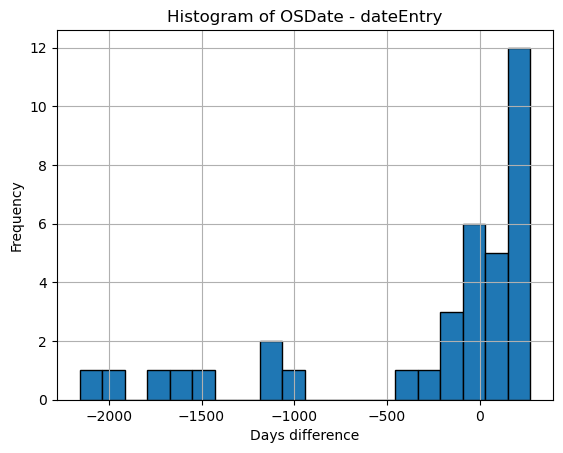

In [19]:
plt.hist(df['OSDate - dateEntry'], bins=20, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('Days difference')
plt.ylabel('Frequency')
plt.title('Histogram of OSDate - dateEntry')
plt.grid(True)

# Show the histogram
plt.show()

In [15]:
df['OSDate - dateEntry'][df['OSDate - dateEntry'] > 0].describe()

count     23.000000
mean     128.391304
std      101.220165
min        4.000000
25%       28.500000
50%      179.000000
75%      223.000000
max      275.000000
Name: OSDate - dateEntry, dtype: float64

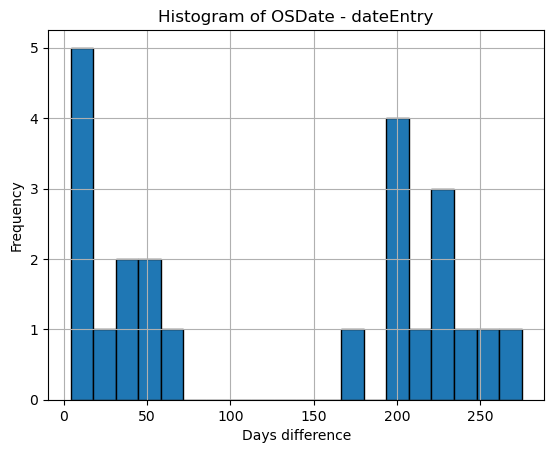

In [20]:
plt.hist(df['OSDate - dateEntry'][df['OSDate - dateEntry'] > 0], bins=20, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('Days difference')
plt.ylabel('Frequency')
plt.title('Histogram of OSDate - dateEntry')
plt.grid(True)

# Show the histogram
plt.show()

In [25]:
df['HDMFDate - dateEntry'].describe()

count     244.000000
mean       44.913934
std       157.208666
min     -1620.000000
25%        43.000000
50%        63.000000
75%        91.000000
max       313.000000
Name: HDMFDate - dateEntry, dtype: float64

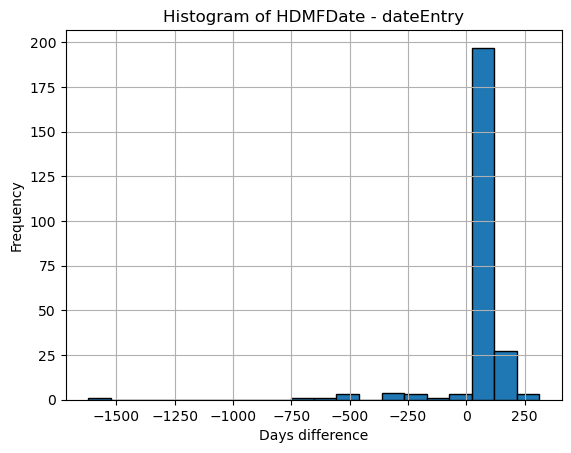

In [18]:
plt.hist(df['HDMFDate - dateEntry'], bins=20, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('Days difference')
plt.ylabel('Frequency')
plt.title('Histogram of HDMFDate - dateEntry')
plt.grid(True)

# Show the histogram
plt.show()

In [21]:
df['HDMFDate - dateEntry'][df['HDMFDate - dateEntry'] > 0].describe()

count    230.000000
mean      75.717391
std       41.672388
min       21.000000
25%       46.000000
50%       65.000000
75%       92.000000
max      313.000000
Name: HDMFDate - dateEntry, dtype: float64

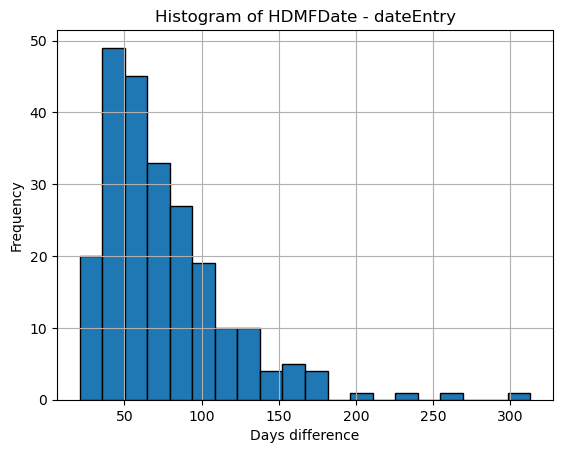

In [22]:
plt.hist(df['HDMFDate - dateEntry'][df['HDMFDate - dateEntry'] > 0], bins=20, edgecolor='k')  # You can adjust the number of bins as needed
plt.xlabel('Days difference')
plt.ylabel('Frequency')
plt.title('Histogram of HDMFDate - dateEntry')
plt.grid(True)

# Show the histogram
plt.show()

In [44]:
df_2 = df.copy().loc[:, ['userId', 'lastFirstName', 'basicMonthlySalary', 'home_ownership_class']]

In [45]:
df_2

,userId,lastFirstName,basicMonthlySalary,home_ownership_class
0,370,"IBALI, HOWARD",19000,1
1,1025,"PATALINGHOG, KIMBERLY",15000,0
2,1105,"TEMILLOSO, DENNIS",20000,0
3,1719,"OSCARES, ELMER",21200,1
4,2081,"LEGASPI, MANNY",19800,0
...,...,...,...,...
1065,12850,"LIPANGO, ARVIN",19000,0
1066,12852,"TEJADA, JERIC",20,0
1067,12853,"RAMOS, RHEALYN",13962,0
1068,12854,"BURGOS, LIEZEL",51000,0


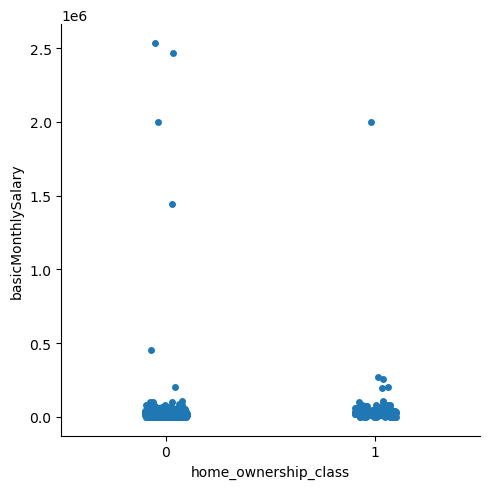

In [46]:
sns.catplot(
    x='home_ownership_class',
    y='basicMonthlySalary',
    data=df_2
)

In [47]:
scaler = RobustScaler()

In [108]:
df.columns
columns = [
    'age', 'basicMonthlySalary', 'preferredNetDisposableIncomeId',
    'workingFamilyCount', 'residentsCount', 'monthlyFamilyIncome', 'food',
    'hygiene', 'houseCleaning', 'fare', 'parking', 'gasoline', 'tuition',
    'allowance', 'uniform', 'otherEducation', 'emergency', 'medicine',
    'water', 'electricity', 'rent', 'repair', 'cinema', 'dineOut',
    'leisure', 'personalCare', 'clothing', 'mobileLoad', 'internet',
    'vehicleLoan', 'informalLenders', 'companyLoan', 'privateLoans',
    'governmentLoans', 'smoking', 'alcohol', 'gambling', 'smallLottery',
    'otherVices', 'savings', 'loanOthers', 'payInsurance', 'loanSSS',
    'payFamilySupport', 'loanPagIbig', 'loanGSIS', 'loanPersonal',
    'houseHasPensioner', 'houseHasPrivateEmployee', 'houseHasBusiness',
    'houseHasFreelancer', 'houseHasGovtEmployee', 'houseHasOFW',
    'houseOnlyFamily', 'houseExtendedFamily',
    'monthlyUtilityBills', 'monthlyVices', 'monthlyExpenses',
    'monthlySoloNetIncome', 'positiveMonthlySoloNetIncome',
    'monthlyFamilyNetIncome', 'positiveMonthlyFamilyNetIncome',
    'monthlySoloNetIncomeWithSavings',
    'positiveMonthlySoloNetIncomeWithSavings',
    'monthlyFamilyNetIncomeWithSavings',
    'positiveMonthlyFamilyNetIncomeWithSavings',
    'monthlyFamilyIncome - basicMonthlySalary',
    'positive monthlyFamilyIncome - basicMonthlySalary',
    'basicMonthlySalary - monthlyExpenses',
    'positive basicMonthlySalary - monthlyExpenses',
    'monthlyFamilyIncome - monthlyExpenses',
    'positive monthlyFamilyIncome - monthlyExpenses',
    'basicMonthlySalary / monthlyFamilyIncome',
    'monthlyExpenses / monthlyFamilyIncome',
    'monthlyVices / monthlyFamilyIncome'
]

In [75]:
res_df = pd.DataFrame(columns=[
    'Variable',
    'Mean Test Precision', 'Std Test Precision', 'Mean Val Precision',
    'Mean Train Precision', 'Mean Test Accuracy', 'Std Test Accuracy'
])

for index, col in enumerate(columns):
    df_2 = df.copy().loc[:, ['userId', 'lastFirstName', col, 'home_ownership_class']]
    t01_logreg_gs, t01_logreg_be, t01_logreg_model_info, t01_logreg_metrics_df = logreg_class2(df_2, 'precision',
                                                                'home_ownership_class', scaler, random_state=0)
    new_row = {
        'Variable': col,
        'Mean Test Precision': t01_logreg_model_info['average_test_precision'],
        'Std Test Precision': t01_logreg_model_info['stdev_test_precision'],
        'Val Precision of Best Model': t01_logreg_model_info['best_cv_score'],
        'Train Precision of Best Model': t01_logreg_model_info['train_score'],
        'Mean Test Accuracy': t01_logreg_model_info['average_test_accuracy'],
        'Std Test Accuracy': t01_logreg_model_info['stdev_test_accuracy']
    }
    res_df = res_df.append(new_row, ignore_index=True)
    print(f'\n=====================\n\n\nDone with {col}. {len(columns) - index + 1} columns left\n\n\n=====================\n')

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.2719407594857509
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.5336658354114713
GridSearchCV Runtime: 6.2308313846588135 secs
Run 1 - Random State: 0
Test Precision: 0.2711864406779661
Run 2 - Random State: 1
Test Precision: 0.2605042016806723
Run 3 - Random State: 2
Test Precision: 0.2127659574468085
Run 4 - Random State: 3
Test Precision: 0.25806451612903225
Run 5 - Random State: 4
Test Precision: 0.265625
Ave Test Precision: 0.25362922318689585
Stdev Test Precision: 0.023392831097881244
Ave Test Accuracy: 0


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.41792755045602437
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6670822942643392
GridSearchCV Runtime: 3.9486300945281982 secs
Run 1 - Random State: 0
Test Precision: 0.42424242424242425
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.3063063063063063
Run 4 - Random State: 3
Test Precision: 0.32947976878612717
Run 5 - Random State: 4
Test Precision: 0.26842105263157895
Ave Test Precision: 0.332356577059954
Stdev Test Precision: 0.057486100235996
Ave Test Accuracy: 0.5813432835820895
Stdev 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.33040033960292586
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6384039900249376
GridSearchCV Runtime: 4.090520858764648 secs
Run 1 - Random State: 0
Test Precision: 0.4044943820224719
Run 2 - Random State: 1
Test Precision: 0.32978723404255317
Run 3 - Random State: 2
Test Precision: 0.39325842696629215
Run 4 - Random State: 3
Test Precision: 0.3645833333333333
Run 5 - Random State: 4
Test Precision: 0.34831460674157305
Ave Test Precision: 0.3680875966212447
Stdev Test Precision: 0.03094023871571617
Ave Test Accuracy: 0.6634328358208956
Stdev Te


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2724595467673271
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6234413965087282
GridSearchCV Runtime: 4.1496312618255615 secs
Run 1 - Random State: 0
Test Precision: 0.32786885245901637
Run 2 - Random State: 1
Test Precision: 0.28169014084507044
Run 3 - Random State: 2
Test Precision: 0.32051282051282054
Run 4 - Random State: 3
Test Precision: 0.2911392405063291
Run 5 - Random State: 4
Test Precision: 0.28378378378378377
Ave Test Precision: 0.30099896762140405
Stdev Test Precision: 0.021617057678368582
Ave Test Accuracy: 0.6455223880597015
Stdev


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.27133808202670107
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.4800498753117207
GridSearchCV Runtime: 4.369429349899292 secs
Run 1 - Random State: 0
Test Precision: 0.22580645161290322
Run 2 - Random State: 1
Test Precision: 0.26666666666666666
Run 3 - Random State: 2
Test Precision: 0.19607843137254902
Run 4 - Random State: 3
Test Precision: 0.27906976744186046
Run 5 - Random State: 4
Test Precision: 0.25308641975308643
Ave Test Precision: 0.24414154736941315
Stdev Test Precision: 0.03336769078942016
Ave Test Accuracy: 0.5037313432835822
Stdev Test Accuracy: 0.06900463436159303
Ave Test Specificity: 0.


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.35333333333333333
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.729426433915212
GridSearchCV Runtime: 4.404484987258911 secs
Run 1 - Random State: 0
Test Precision: 0.391304347826087
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 0.3
Run 4 - Random State: 3
Test Precision: 0.4
Run 5 - Random State: 4
Test Precision: 0.4
Ave Test Precision: 0.3982608695652174
Stdev Test Precision: 0.07081753224552474
Ave Test Accuracy: 0.7402985074626864
Stdev Test Accuracy: 0.007737478116913322
Ave Test Specificity: 0.9485148514851485
Ave Test Recall: 0.10303030303030303
Ave Tes


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.34123467464930873
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.32917705735660846
GridSearchCV Runtime: 4.322758913040161 secs
Run 1 - Random State: 0
Test Precision: 0.2555066079295154
Run 2 - Random State: 1
Test Precision: 0.2838709677419355
Run 3 - Random State: 2
Test Precision: 0.2828282828282828
Run 4 - Random State: 3
Test Precision: 0.255
Run 5 - Random State: 4
Test Precision: 0.23387096774193547
Ave Test Precision: 0.26221536524833383
Stdev Test Precision: 0.021179773847642008
Ave Test Accuracy: 0.41716417910447756
Stdev Test Accuracy: 0.1320


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.36278429903429904
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.206760406494141 secs
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2
Run 4 - Random State: 3
Test Precision: 0.2608695652173913
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.14142764438676184
Stdev Test Precision: 0.13104606857292384
Ave Test Accuracy: 0.6395522388059701
Stdev Test Accuracy: 0.22052207237899468
Ave Test Specificity: 0.7752475247524753
Ave Test Recall: 0.22424242


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2924065776970142
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5224438902743143
GridSearchCV Runtime: 4.267999172210693 secs
Run 1 - Random State: 0
Test Precision: 0.23484848484848486
Run 2 - Random State: 1
Test Precision: 0.2222222222222222
Run 3 - Random State: 2
Test Precision: 0.296875
Run 4 - Random State: 3
Test Precision: 0.2
Run 5 - Random State: 4
Test Precision: 0.24242424242424243
Ave Test Precision: 0.2392739898989899
Stdev Test Precision: 0.03598817380081265
Ave Test Accuracy: 0.5798507462686567
Stdev Tes


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.26155249978779394
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6047381546134664
GridSearchCV Runtime: 4.25722336769104 secs
Run 1 - Random State: 0
Test Precision: 0.2549019607843137
Run 2 - Random State: 1
Test Precision: 0.27835051546391754
Run 3 - Random State: 2
Test Precision: 0.24175824175824176
Run 4 - Random State: 3
Test Precision: 0.23404255319148937
Run 5 - Random State: 4
Test Precision: 0.3
Ave Test Precision: 0.2618106542395925
Stdev Test Precision: 0.027170249659907404
Ave Test Accuracy: 0.5850


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.28951914098972925
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.7069825436408977
GridSearchCV Runtime: 4.4770941734313965 secs
Run 1 - Random State: 0
Test Precision: 0.15151515151515152
Run 2 - Random State: 1
Test Precision: 0.21739130434782608
Run 3 - Random State: 2
Test Precision: 0.25
Run 4 - Random State: 3
Test Precision: 0.24166666666666667
Run 5 - Random State: 4
Test Precision: 0.2384937238493724
Ave Test Precision: 0.21981336927580336
Stdev Test Precision: 0.040025828773816614
Ave Test Accuracy: 0.4388059701492537
Stdev T


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.35056738714628083
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7518703241895262
GridSearchCV Runtime: 4.268959999084473 secs
Run 1 - Random State: 0
Test Precision: 0.375
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.29545454545454547
Run 5 - Random State: 4
Test Precision: 0.5416666666666666
Ave Test Precision: 0.24242424242424238
Stdev Test Precision: 0.23847096240039925
Ave Test Accuracy: 0.7358208955223882
Stdev Test Accuracy: 0.029663592409480286
Ave Te


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.2765441574615398
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.385286783042394
GridSearchCV Runtime: 4.523259878158569 secs
Run 1 - Random State: 0
Test Precision: 0.26066350710900477
Run 2 - Random State: 1
Test Precision: 0.19298245614035087
Run 3 - Random State: 2
Test Precision: 0.24861878453038674
Run 4 - Random State: 3
Test Precision: 0.24644549763033174
Run 5 - Random State: 4
Test Precision: 0.24878048780487805
Ave Test Precision: 0.2394981466429904
Stdev Test Precision: 0.02659556130848562
Ave Test Accuracy: 0


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4361706349206349
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.743142144638404
GridSearchCV Runtime: 4.321817398071289 secs
Run 1 - Random State: 0
Test Precision: 0.13043478260869565
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.2462686567164179
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.17534068786502272
Stdev Test Precision: 0.2085303932824841
Ave Test Accuracy: 0.6395522388059701
Stdev Test Accuracy: 0.22156137040428409
Ave Test S


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.24231097870381357
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5798004987531172
GridSearchCV Runtime: 4.324409246444702 secs
Run 1 - Random State: 0
Test Precision: 0.17073170731707318
Run 2 - Random State: 1
Test Precision: 0.26424870466321243
Run 3 - Random State: 2
Test Precision: 0.2529411764705882
Run 4 - Random State: 3
Test Precision: 0.26424870466321243
Run 5 - Random State: 4
Test Precision: 0.2236842105263158
Ave Test Precision: 0.2351709007280804
Stdev Test Precision: 0.039658459887510863
Ave Test Accuracy


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.35
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7094763092269327
GridSearchCV Runtime: 4.344894886016846 secs
Run 1 - Random State: 0
Test Precision: 0.2702702702702703
Run 2 - Random State: 1
Test Precision: 0.37037037037037035
Run 3 - Random State: 2
Test Precision: 0.25396825396825395
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.23868312757201646
Ave Test Precision: 0.2266584044361822
Stdev Test Precision: 0.13676583833665623
Ave Test Accuracy: 0.6164179104477612
Stdev Test Accuracy: 0.19263274275123088


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2650908137498526
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6172069825436409
GridSearchCV Runtime: 4.515530586242676 secs
Run 1 - Random State: 0
Test Precision: 0.3013698630136986
Run 2 - Random State: 1
Test Precision: 0.2876712328767123
Run 3 - Random State: 2
Test Precision: 0.22388059701492538
Run 4 - Random State: 3
Test Precision: 0.2569444444444444
Run 5 - Random State: 4
Test Precision: 0.3235294117647059
Ave Test Precision: 0.2786791098228973
Stdev Test Precision: 0.038995354937258205
Ave Test Accuracy: 0.6


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.30481460434358987
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5972568578553616
GridSearchCV Runtime: 4.193583250045776 secs
Run 1 - Random State: 0
Test Precision: 0.25
Run 2 - Random State: 1
Test Precision: 0.2388888888888889
Run 3 - Random State: 2
Test Precision: 0.26582278481012656
Run 4 - Random State: 3
Test Precision: 0.22404371584699453
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.19575107790920201
Stdev Test Precision: 0.11049074424610782
Ave Test Accuracy: 0.5567164179104478
Stdev Test Accuracy: 0.161472775848


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3037076689150119
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.3672285079956055 secs
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2462686567164179
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.2317596566523605
Ave Test Precision: 0.24485939401703924
Stdev Test Precision: 0.1769381437264725
Ave Test Accuracy: 0.45746268656716416
Stdev Test Accuracy: 0.2709736329145468
Ave Test Specificity: 0.42079207920792083
Ave Test Rec


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3996855953375717
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.6770573566084788
GridSearchCV Runtime: 4.312411546707153 secs
Run 1 - Random State: 0
Test Precision: 0.21739130434782608
Run 2 - Random State: 1
Test Precision: 0.16666666666666666
Run 3 - Random State: 2
Test Precision: 0.3018867924528302
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.2553191489361702
Ave Test Precision: 0.2882527824806986
Stdev Test Precision: 0.12836659146313203
Ave Test Accuracy: 0.6985074626865672
Stdev Test Accuracy: 0.0444


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.27156738349006126
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5498753117206983
GridSearchCV Runtime: 4.375663757324219 secs
Run 1 - Random State: 0
Test Precision: 0.216
Run 2 - Random State: 1
Test Precision: 0.22330097087378642
Run 3 - Random State: 2
Test Precision: 0.25210084033613445
Run 4 - Random State: 3
Test Precision: 0.22772277227722773
Run 5 - Random State: 4
Test Precision: 0.24561403508771928
Ave Test Precision: 0.23294772371497358
Stdev Test Precision: 0.01528776158500623
Ave Test Accuracy: 0.52985074626865


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.26162276200250884
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7418952618453866
GridSearchCV Runtime: 4.3937859535217285 secs
Run 1 - Random State: 0
Test Precision: 0.2857142857142857
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.46153846153846156
Run 4 - Random State: 3
Test Precision: 0.42857142857142855
Run 5 - Random State: 4
Test Precision: 0.3076923076923077
Ave Test Precision: 0.3633699633699634
Stdev Test Precision: 0.07733189809993642
Ave Test Accuracy: 0.7447761194029849
Stdev Test


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.32722222222222225
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7069825436408977
GridSearchCV Runtime: 4.731696844100952 secs
Run 1 - Random State: 0
Test Precision: 0.2727272727272727
Run 2 - Random State: 1
Test Precision: 0.36363636363636365
Run 3 - Random State: 2
Test Precision: 0.21428571428571427
Run 4 - Random State: 3
Test Precision: 0.15384615384615385
Run 5 - Random State: 4
Test Precision: 0.3076923076923077
Ave Test Precision: 0.26243756243756244
Stdev Test Precision: 0.08140295137508442
Ave Test Accuracy: 0.7052238805970149
Stdev Test Accuracy: 0.018279774199874463
Ave Test Specificity: 0


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.31140247007894073
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.6670822942643392
GridSearchCV Runtime: 4.43420934677124 secs
Run 1 - Random State: 0
Test Precision: 0.375
Run 2 - Random State: 1
Test Precision: 0.2462686567164179
Run 3 - Random State: 2
Test Precision: 0.2462686567164179
Run 4 - Random State: 3
Test Precision: 0.30597014925373134
Run 5 - Random State: 4
Test Precision: 0.46153846153846156
Ave Test Precision: 0.32700918484500574
Stdev Test Precision: 0.09203525331426364
Ave Test Accuracy: 0.5022388059701492
Stdev Test Accuracy: 0.2441621


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3933933663709828
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.25561097256857856
GridSearchCV Runtime: 4.4185075759887695 secs
Run 1 - Random State: 0
Test Precision: 0.24609375
Run 2 - Random State: 1
Test Precision: 0.30612244897959184
Run 3 - Random State: 2
Test Precision: 0.4117647058823529
Run 4 - Random State: 3
Test Precision: 0.2222222222222222
Run 5 - Random State: 4
Test Precision: 0.35
Ave Test Precision: 0.30724062541683345
Stdev Test Precision: 0.07700968621779661
Ave Test Accuracy: 0.6238805970149254
Stdev Test Accuracy: 0.199712284696006
Ave Test Specificity: 0.7257425742574257
Ave Te


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.2952874779541447
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.4820451736450195 secs
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.2462686567164179
Run 3 - Random State: 2
Test Precision: 0.24436090225563908
Run 4 - Random State: 3
Test Precision: 0.21428571428571427
Run 5 - Random State: 4
Test Precision: 0.2462686567164179
Ave Test Precision: 0.23949051733812143
Stdev Test Precision: 0.014114108778543692
Ave Test Accuracy: 0.3358208955223881
Stdev Test Accuracy: 0.20024489350744387
Ave Test Specificity: 0.


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.33858160792371317
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.5548628428927681
GridSearchCV Runtime: 4.506165027618408 secs
Run 1 - Random State: 0
Test Precision: 0.2830188679245283
Run 2 - Random State: 1
Test Precision: 0.4186046511627907
Run 3 - Random State: 2
Test Precision: 0.22699386503067484
Run 4 - Random State: 3
Test Precision: 0.2222222222222222
Run 5 - Random State: 4
Test Precision: 0.23893805309734514
Ave Test Precision: 0.27795553188751226
Stdev Test Precision: 0.08220928942484357
Ave Test Accuracy: 0.5552238805970149
Stdev Test Accuracy: 0.11257283971491158
Ave Test Specificity: 0.6
A


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.34035493827160496
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.743142144638404
GridSearchCV Runtime: 4.444406270980835 secs
Run 1 - Random State: 0
Test Precision: 0.29411764705882354
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.17391304347826086
Run 5 - Random State: 4
Test Precision: 0.2727272727272727
Ave Test Precision: 0.14815159265287142
Stdev Test Precision: 0.14264171047123156
Ave Test Accuracy: 0.7223880597014926
Stdev Test Accuracy: 0.04649978381992352
Ave Test Specificity: 0.9425742574257425
Ave Test Recall


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3305246913580247
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.756857855361596
GridSearchCV Runtime: 4.517886638641357 secs
Run 1 - Random State: 0
Test Precision: 0.5
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.18994413407821228
Run 4 - Random State: 3
Test Precision: 0.328125
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.20361382681564244
Stdev Test Precision: 0.21590034584454101
Ave Test Accuracy: 0.6537313432835822
Stdev Test Accuracy: 0.17909281678458255
Ave Test Specificit


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.33916666666666667
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7331670822942643
GridSearchCV Runtime: 4.650293350219727 secs
Run 1 - Random State: 0
Test Precision: 0.2857142857142857
Run 2 - Random State: 1
Test Precision: 0.5454545454545454
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.4482758620689655
Run 5 - Random State: 4
Test Precision: 0.2571428571428571
Ave Test Precision: 0.40731751007613076
Stdev Test Precision: 0.12912130114588072
Ave Test Accuracy: 0.7328358208955225
Stdev Test Accuracy: 0.02


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.45
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7468827930174564
GridSearchCV Runtime: 4.818542003631592 secs
Run 1 - Random State: 0
Test Precision: 0.23076923076923078
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.5454545454545454
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.4166666666666667
Ave Test Precision: 0.35524475524475524
Stdev Test Precision: 0.1294248243233685
Ave Test Accuracy: 0.7432835820895523
Stdev Test Accuracy: 0.011005881495337775
Ave Test Specificity: 0.9673267326732674
Ave Test Recal


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2646733036185091
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.7231920199501247
GridSearchCV Runtime: 4.530595064163208 secs
Run 1 - Random State: 0
Test Precision: 0.15
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.2388663967611336
Run 4 - Random State: 3
Test Precision: 0.2
Run 5 - Random State: 4
Test Precision: 0.25301204819277107
Ave Test Precision: 0.21837568899078094
Stdev Test Precision: 0.04368221698058891
Ave Test Accuracy: 0.4544776119402985
Stdev Test Accu


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.38190476190476186
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.7381546134663342
GridSearchCV Runtime: 4.794448375701904 secs
Run 1 - Random State: 0
Test Precision: 0.1
Run 2 - Random State: 1
Test Precision: 0.1111111111111111
Run 3 - Random State: 2
Test Precision: 0.23715415019762845
Run 4 - Random State: 3
Test Precision: 0.26666666666666666
Run 5 - Random State: 4
Test Precision: 0.42857142857142855
Ave Test Precision: 0.22870067130936697
Stdev Test Precision: 0.13402645744441252
Ave Test Accuracy: 0.6313432835820896
Stdev Test


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-05, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2510807142769716
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-05, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.48129675810473815
GridSearchCV Runtime: 4.600949287414551 secs
Run 1 - Random State: 0
Test Precision: 0.2804878048780488
Run 2 - Random State: 1
Test Precision: 0.2621951219512195
Run 3 - Random State: 2
Test Precision: 0.211864406779661
Run 4 - Random State: 3
Test Precision: 0.23
Run 5 - Random State: 4
Test Precision: 0.20175438596491227
Ave Test Precision: 0.23726034391476833
Stdev Test Precision: 0.03334927211996916
Ave Test Accuracy: 0.5
Stdev Test Ac


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3422366522366523
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7206982543640897
GridSearchCV Runtime: 4.6834447383880615 secs
Run 1 - Random State: 0
Test Precision: 0.2222222222222222
Run 2 - Random State: 1
Test Precision: 0.4
Run 3 - Random State: 2
Test Precision: 0.3548387096774194
Run 4 - Random State: 3
Test Precision: 0.36363636363636365
Run 5 - Random State: 4
Test Precision: 0.25
Ave Test Precision: 0.31813945910720104
Stdev Test Precision: 0.07739679206608645
Ave Test Accuracy: 0.7238805970149254
Stdev Test Accuracy: 0.00875077567131236


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.34934889227126675
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.756857855361596
GridSearchCV Runtime: 4.741650104522705 secs
Run 1 - Random State: 0
Test Precision: 0.5
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2727272727272727
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.2413793103448276
Ave Test Precision: 0.3028213166144201
Stdev Test Precision: 0.20865065766212348
Ave Test Accuracy: 0.7313432835820896
Stdev Test Accuracy: 0.030656113293199595
Ave Tes


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.42333333333333334
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7418952618453866
GridSearchCV Runtime: 4.965595483779907 secs
Run 1 - Random State: 0
Test Precision: 0.1111111111111111
Run 2 - Random State: 1
Test Precision: 0.16666666666666666
Run 3 - Random State: 2
Test Precision: 0.4166666666666667
Run 4 - Random State: 3
Test Precision: 0.14285714285714285
Run 5 - Random State: 4
Test Precision: 0.16666666666666666
Ave Test Precision: 0.2007936507936508
Stdev Test Precision: 0.12281088912338513
Ave Test Accuracy: 0.7373134328358208
Stdev Test Accuracy: 0.0067783216882779706
Ave Test Specificity: 0.9


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.38666666666666666
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7381546134663342
GridSearchCV Runtime: 5.33472466468811 secs
Run 1 - Random State: 0
Test Precision: 0.125
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.23577235772357724
Run 4 - Random State: 3
Test Precision: 0.14285714285714285
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.150725900116144
Stdev Test Precision: 0.10066067144462562
Ave Test Accuracy: 0.6402985074626865
Stdev Test Accuracy: 0.20779595801964662
Ave Test Spe


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.4
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7369077306733167
GridSearchCV Runtime: 4.9686079025268555 secs
Run 1 - Random State: 0
Test Precision: 0.2222222222222222
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.14285714285714285
Run 5 - Random State: 4
Test Precision: 0.14285714285714285
Ave Test Precision: 0.10158730158730159
Stdev Test Precision: 0.0982333234715289
Ave Test Accuracy: 0.7388059701492538
Stdev Test Accuracy: 0.008343537229476828
Ave Test S


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.41818609022556397
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.479140996932983 secs
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.2462686567164179
Run 4 - Random State: 3
Test Precision: 0.3076923076923077
Run 5 - Random State: 4
Test Precision: 0.2543859649122807
Ave Test Precision: 0.2775897838741515
Stdev Test Precision: 0.040354517943496794
Ave Test Accuracy: 0.49850746268656715
Stdev Test Accura


910 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2829761904761905
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7256857855361596
GridSearchCV Runtime: 4.534821510314941 secs
Run 1 - Random State: 0
Test Precision: 0.2777777777777778
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2857142857142857
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.1126984126984127
Stdev Test Precision: 0.15434416555597125
Ave Test Accuracy: 0.7455223880597015
Stdev Test Accuracy: 0.013033021788487286
Ave Test Specif


910 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.33936507936507937
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7169576059850374
GridSearchCV Runtime: 4.663201808929443 secs
Run 1 - Random State: 0
Test Precision: 0.4166666666666667
Run 2 - Random State: 1
Test Precision: 0.35714285714285715
Run 3 - Random State: 2
Test Precision: 0.34615384615384615
Run 4 - Random State: 3
Test Precision: 0.35714285714285715
Run 5 - Random State: 4
Test Precision: 0.4166666666666667
Ave Test Precision: 0.3787545787545788
Stdev Test Precision: 0.03489840113765008
Ave Test Accuracy: 0.7


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2611472392843984
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.4476309226932668
GridSearchCV Runtime: 4.882431268692017 secs
Run 1 - Random State: 0
Test Precision: 0.26666666666666666
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.26737967914438504
Run 5 - Random State: 4
Test Precision: 0.23125
Ave Test Precision: 0.20305926916221032
Stdev Test Precision: 0.11447077407247937
Ave Test Accuracy: 0.4977611940298508
Stdev Test Accuracy: 0.1431494241335313
Ave Test Specificity: 0.48415841584158414
Ave Test Recall: 0.53939393


780 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.24495471161105836
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.3566084788029925
GridSearchCV Runtime: 4.519453287124634 secs
Run 1 - Random State: 0
Test Precision: 0.23880597014925373
Run 2 - Random State: 1
Test Precision: 0.20634920634920634
Run 3 - Random State: 2
Test Precision: 0.2857142857142857
Run 4 - Random State: 3
Test Precision: 0.18571428571428572
Run 5 - Random State: 4
Test Precision: 0.25
Ave Test Precision: 0.23331674958540632
Stdev Test Precision: 0.038881895317645854
Ave Test Accuracy: 0.5694029850746269
Stdev Test Accuracy: 0.11818996719198696
Ave Test Specificity: 0.647524752475247


780 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2657915475780755
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.43640897755610975
GridSearchCV Runtime: 4.436023473739624 secs
Run 1 - Random State: 0
Test Precision: 0.25925925925925924
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.288135593220339
Run 4 - Random State: 3
Test Precision: 0.2617801047120419
Run 5 - Random State: 4
Test Precision: 0.2541436464088398
Ave Test Precision: 0.26266372072009603
Stdev Test Precision: 0.014951161430659526
Ave Test Accuracy: 0.4298507462686567
Stdev Test Accuracy: 0.025086173602942703
Ave Test Specificity: 0.3326732673267327



845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-05, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.11949358974358974
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-05, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.2581047381546135
GridSearchCV Runtime: 5.5879809856414795 secs
Run 1 - Random State: 0
Test Precision: 0.25
Run 2 - Random State: 1
Test Precision: 0.14285714285714285
Run 3 - Random State: 2
Test Precision: 0.24806201550387597
Run 4 - Random State: 3
Test Precision: 0.23846153846153847
Run 5 - Random State: 4
Test Precision: 0.2471042471042471
Ave Test Precision: 0.22529698878536086
Stdev Test Precision: 0.04629707141061084
Ave Test Accuracy: 0.3567164179104477
Stdev Test Accuracy:


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3420238095238095
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.726932668329177
GridSearchCV Runtime: 5.627745628356934 secs
Run 1 - Random State: 0
Test Precision: 0.35
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.2727272727272727
Run 4 - Random State: 3
Test Precision: 0.2857142857142857
Run 5 - Random State: 4
Test Precision: 0.4
Ave Test Precision: 0.3283549783549783
Stdev Test Precision: 0.051329743836055444
Ave Test Accuracy: 0.7276119402985074
Stdev Test Accuracy: 0.008750775671312359


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.35
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7456359102244389
GridSearchCV Runtime: 5.414266109466553 secs
Run 1 - Random State: 0
Test Precision: 0.2
Run 2 - Random State: 1
Test Precision: 0.18181818181818182
Run 3 - Random State: 2
Test Precision: 0.3
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.6
Ave Test Precision: 0.32303030303030306
Stdev Test Precision: 0.16764999177716466
Ave Test Accuracy: 0.7425373134328359
Stdev Test Accuracy: 0.01087864159486063
Ave Test Specificity: 0.9742


975 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
130 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2225467444686368
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.35785536159601
GridSearchCV Runtime: 5.130429983139038 secs
Run 1 - Random State: 0
Test Precision: 0.2350230414746544
Run 2 - Random State: 1
Test Precision: 0.16666666666666666
Run 3 - Random State: 2
Test Precision: 0.2727272727272727
Run 4 - Random State: 3
Test Precision: 0.24193548387096775
Run 5 - Random State: 4
Test Precision: 0.21311475409836064
Ave Test Precision: 0.22589344376758444
Stdev Test Precision: 0.0393865782196834
Ave Test Accuracy: 0.5656716417910448


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.22947674419304326
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.3179551122194514
GridSearchCV Runtime: 5.604830741882324 secs
Run 1 - Random State: 0
Test Precision: 0.2145748987854251
Run 2 - Random State: 1
Test Precision: 0.3448275862068966
Run 3 - Random State: 2
Test Precision: 0.21982758620689655
Run 4 - Random State: 3
Test Precision: 0.2647058823529412
Run 5 - Random State: 4
Test Precision: 0.23529411764705882
Ave Test Precision: 0.25584601423984366
Stdev Test Precision: 0.053430398639459815
Ave Test 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-05, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.24521431392706322
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-05, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.2817955112219451
GridSearchCV Runtime: 5.5226826667785645 secs
Run 1 - Random State: 0
Test Precision: 0.23293172690763053
Run 2 - Random State: 1
Test Precision: 0.236
Run 3 - Random State: 2
Test Precision: 0.29411764705882354
Run 4 - Random State: 3
Test Precision: 0.2857142857142857
Run 5 - Random State: 4
Test Precision: 0.29411764705882354
Ave Test Precision: 0.2685762613479127
Stdev Test Precision: 0.03134558296682887
Ave Test Accuracy: 0.5388059701492537
Stdev Test Accuracy:


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.24919459136576155
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.29800498753117205
GridSearchCV Runtime: 5.398139476776123 secs
Run 1 - Random State: 0
Test Precision: 0.25311203319502074
Run 2 - Random State: 1
Test Precision: 0.26141078838174275
Run 3 - Random State: 2
Test Precision: 0.25210084033613445
Run 4 - Random State: 3
Test Precision: 0.24481327800829875
Run 5 - Random State: 4
Test Precision: 0.2625
Ave Test Precision: 0.25478738798423933
Stdev Test Precision: 0.007294879003087672
Ave Test Accurac


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.2636163131673967
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6596009975062345
GridSearchCV Runtime: 5.556886911392212 secs
Run 1 - Random State: 0
Test Precision: 0.36538461538461536
Run 2 - Random State: 1
Test Precision: 0.27586206896551724
Run 3 - Random State: 2
Test Precision: 0.3275862068965517
Run 4 - Random State: 3
Test Precision: 0.3103448275862069
Run 5 - Random State: 4
Test Precision: 0.2903225806451613
Ave Test Precision: 0.3139000598956105
Stdev Test Precision: 0.03483315960478191
Ave Test Accuracy: 0.673


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2996199340112383
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6346633416458853
GridSearchCV Runtime: 5.472182750701904 secs
Run 1 - Random State: 0
Test Precision: 0.20512820512820512
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.38666666666666666
Run 4 - Random State: 3
Test Precision: 0.2328767123287671
Run 5 - Random State: 4
Test Precision: 0.2558139534883721
Ave Test Precision: 0.26609710752240223
Stdev Test Precision: 0.07021873047074419
Ave Test Accuracy: 0.6134328358208955
Stdev Test Accuracy: 0.


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3103719517496607
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6795511221945137
GridSearchCV Runtime: 5.091847658157349 secs
Run 1 - Random State: 0
Test Precision: 0.24193548387096775
Run 2 - Random State: 1
Test Precision: 0.2698412698412698
Run 3 - Random State: 2
Test Precision: 0.4230769230769231
Run 4 - Random State: 3
Test Precision: 0.2978723404255319
Run 5 - Random State: 4
Test Precision: 0.25396825396825395
Ave Test Precision: 0.2973388542365893
Stdev Test Precision: 0.07334338096633872
Ave Test Accuracy: 0.6649253731343284
Stdev Test


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.43807692307692303
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7394014962593516
GridSearchCV Runtime: 5.12712287902832 secs
Run 1 - Random State: 0
Test Precision: 0.23076923076923078
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.14285714285714285
Run 5 - Random State: 4
Test Precision: 0.2727272727272727
Ave Test Precision: 0.32927072927072926
Stdev Test Precision: 0.16274727390343235
Ave Test Accuracy: 0.741044776119403
Stdev Test Accuracy: 0.01197522875


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.32306798140131476
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7481296758104738
GridSearchCV Runtime: 5.610814809799194 secs
Run 1 - Random State: 0
Test Precision: 0.3333333333333333
Run 2 - Random State: 1
Test Precision: 0.42857142857142855
Run 3 - Random State: 2
Test Precision: 0.36363636363636365
Run 4 - Random State: 3
Test Precision: 0.36363636363636365
Run 5 - Random State: 4
Test Precision: 0.4444444444444444
Ave Test Precision: 0.38672438672438675
Stdev Test Precision: 0.04743284246433938
Ave Test Accuracy: 0.7470149253731343
Stdev Test Accuracy: 0.004087481772426625
Ave Test Specific


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.380297619047619
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7119700748129676
GridSearchCV Runtime: 5.064406394958496 secs
Run 1 - Random State: 0
Test Precision: 0.3225806451612903
Run 2 - Random State: 1
Test Precision: 0.5714285714285714
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.3157894736842105
Run 5 - Random State: 4
Test Precision: 0.2857142857142857
Ave Test Precision: 0.39910259519767155
Stdev Test Precision: 0.12799425979410642
Ave Test Accuracy: 0.7283582089552239
Stdev Test Accuracy: 0.030473905953873746
Ave Test Specificity: 0.9287128712871286



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.39999999999999997
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7518703241895262
GridSearchCV Runtime: 5.0297582149505615 secs
Run 1 - Random State: 0
Test Precision: 0.4
Run 2 - Random State: 1
Test Precision: 0.2857142857142857
Run 3 - Random State: 2
Test Precision: 0.3870967741935484
Run 4 - Random State: 3
Test Precision: 0.3
Run 5 - Random State: 4
Test Precision: 0.2727272727272727
Ave Test Precision: 0.32910766652702134
Stdev Test Precision: 0.059785972659199466
Ave Test Accuracy: 0.7358208955223879
Stdev Test Accuracy: 0.007177382112563941
Ave Test Specificity: 0.9504950495049505
Ave Test Re


1105 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
182 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mo

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.259894230383722
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.415211970074813
GridSearchCV Runtime: 4.621138572692871 secs
Run 1 - Random State: 0
Test Precision: 0.2736842105263158
Run 2 - Random State: 1
Test Precision: 0.25263157894736843
Run 3 - Random State: 2
Test Precision: 0.22941176470588234
Run 4 - Random State: 3
Test Precision: 0.28888888888888886
Run 5 - Random State: 4
Test Precision: 0.2512820512820513
Ave Test Precision: 0.25917969887010134
Stdev Test Precision: 0.022827600872137695
Ave Test Accuracy: 0.42164179104477606
Stdev Test Accuracy: 0.03099486516014207
Ave Test Specificity: 0.321


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.42333333333333334
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7468827930174564
GridSearchCV Runtime: 4.775115966796875 secs
Run 1 - Random State: 0
Test Precision: 0.38461538461538464
Run 2 - Random State: 1
Test Precision: 0.4117647058823529
Run 3 - Random State: 2
Test Precision: 0.2916666666666667
Run 4 - Random State: 3
Test Precision: 0.4444444444444444
Run 5 - Random State: 4
Test Precision: 0.3333333333333333
Ave Test Precision: 0.3731649069884364
Stdev Test Precision: 0.061094901194505016
Ave Test Accuracy: 0.7365671641791045
Stdev Test Accuracy: 0.013086326803544922
Ave Test Specificity:


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.22195442571788887
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6907730673316709
GridSearchCV Runtime: 4.9040961265563965 secs
Run 1 - Random State: 0
Test Precision: 0.21621621621621623
Run 2 - Random State: 1
Test Precision: 0.24669603524229075
Run 3 - Random State: 2
Test Precision: 0.2409090909090909
Run 4 - Random State: 3
Test Precision: 0.2565217391304348
Run 5 - Random State: 4
Test Precision: 0.2297872340425532
Ave Test Precision: 0.2380260631081172
Stdev Test Precision: 0.015565330252285143
Ave Test 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4336507936507936
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7344139650872819
GridSearchCV Runtime: 4.6366143226623535 secs
Run 1 - Random State: 0
Test Precision: 0.4375
Run 2 - Random State: 1
Test Precision: 0.2903225806451613
Run 3 - Random State: 2
Test Precision: 0.47619047619047616
Run 4 - Random State: 3
Test Precision: 0.2631578947368421
Run 5 - Random State: 4
Test Precision: 0.3103448275862069
Ave Test Precision: 0.35550315583173725
Stdev Test Precision: 0.09500571165355737
Ave Test Accuracy: 0.726865671641791
Stdev Test Accuracy: 0.02016306878523329
Ave Test Specificity: 0.9247524752475247
Ave


910 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2606301088307362
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6384039900249376
GridSearchCV Runtime: 4.614759683609009 secs
Run 1 - Random State: 0
Test Precision: 0.16393442622950818
Run 2 - Random State: 1
Test Precision: 0.24390243902439024
Run 3 - Random State: 2
Test Precision: 0.22613065326633167
Run 4 - Random State: 3
Test Precision: 0.2660098522167488
Run 5 - Random State: 4
Test Precision: 0.24537037037037038
Ave Test Precision: 0.22906954822146983
Stdev Test Precision: 0.039056173430170205
Ave Te


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3916666666666667
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7468827930174564
GridSearchCV Runtime: 4.783532381057739 secs
Run 1 - Random State: 0
Test Precision: 0.3888888888888889
Run 2 - Random State: 1
Test Precision: 0.48148148148148145
Run 3 - Random State: 2
Test Precision: 0.3181818181818182
Run 4 - Random State: 3
Test Precision: 0.2972972972972973
Run 5 - Random State: 4
Test Precision: 0.24242424242424243
Ave Test Precision: 0.3456547456547457
Stdev Test Precision: 0.09228737001797055
Ave Test Accuracy: 0.714179104477612
Stdev Test Ac


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.21092712842712844
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.7082294264339152
GridSearchCV Runtime: 4.994728326797485 secs
Run 1 - Random State: 0
Test Precision: 0.15384615384615385
Run 2 - Random State: 1
Test Precision: 0.24583333333333332
Run 3 - Random State: 2
Test Precision: 0.23809523809523808
Run 4 - Random State: 3
Test Precision: 0.2489451476793249
Run 5 - Random State: 4
Test Precision: 0.22950819672131148
Ave Test Precision: 0.22324561393507233
Stdev Test Precision: 0.039517994141190345
Ave Tes


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.2852403100775194
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6159600997506235
GridSearchCV Runtime: 4.725091218948364 secs
Run 1 - Random State: 0
Test Precision: 0.2289156626506024
Run 2 - Random State: 1
Test Precision: 0.375
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.12078313253012048
Stdev Test Precision: 0.17326609238958235
Ave Test Accuracy: 0.7134328358208955
Stdev Test Accuracy: 0.07135553819687412
Ave Test Specificity: 


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.23857484303136473
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6159600997506235
GridSearchCV Runtime: 4.6933815479278564 secs
Run 1 - Random State: 0
Test Precision: 0.2345679012345679
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2289156626506024
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.09269671277703406
Stdev Test Precision: 0.1269459315003977
Ave Test Accuracy: 0.6880597014925373
Stdev Test Accuracy: 0.089963


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.39999999999999997
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7518703241895262
GridSearchCV Runtime: 4.878476858139038 secs
Run 1 - Random State: 0
Test Precision: 0.4
Run 2 - Random State: 1
Test Precision: 0.2857142857142857
Run 3 - Random State: 2
Test Precision: 0.3870967741935484
Run 4 - Random State: 3
Test Precision: 0.3
Run 5 - Random State: 4
Test Precision: 0.2727272727272727
Ave Test Precision: 0.32910766652702134
Stdev Test Precision: 0.059785972659199466
Ave Test Accuracy: 0.7358208955223879
Stdev Test Accuracy: 0.007177382112563941
Ave Test Specificity: 0.9504950495049505
Ave Test Rec


1105 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
182 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mo

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.259894230383722
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.415211970074813
GridSearchCV Runtime: 4.592023849487305 secs
Run 1 - Random State: 0
Test Precision: 0.2736842105263158
Run 2 - Random State: 1
Test Precision: 0.25263157894736843
Run 3 - Random State: 2
Test Precision: 0.22941176470588234
Run 4 - Random State: 3
Test Precision: 0.28888888888888886
Run 5 - Random State: 4
Test Precision: 0.2512820512820513
Ave Test Precision: 0.25917969887010134
Stdev Test Precision: 0.022827600872137695
Ave Test Accuracy: 0.42164179104477606
Stdev Test Accuracy: 0.03099486516014207
Ave Test Specificity: 0.321


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.42333333333333334
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7468827930174564
GridSearchCV Runtime: 4.762001037597656 secs
Run 1 - Random State: 0
Test Precision: 0.38461538461538464
Run 2 - Random State: 1
Test Precision: 0.4117647058823529
Run 3 - Random State: 2
Test Precision: 0.2916666666666667
Run 4 - Random State: 3
Test Precision: 0.4444444444444444
Run 5 - Random State: 4
Test Precision: 0.3333333333333333
Ave Test Precision: 0.3731649069884364
Stdev Test Precision: 0.061094901194505016
Ave Test Accuracy: 0.7365671641791045
Stdev Test Accuracy: 0.013086326803544922
Ave Test Specificity:


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.22195442571788887
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6907730673316709
GridSearchCV Runtime: 4.815627336502075 secs
Run 1 - Random State: 0
Test Precision: 0.21621621621621623
Run 2 - Random State: 1
Test Precision: 0.24669603524229075
Run 3 - Random State: 2
Test Precision: 0.2409090909090909
Run 4 - Random State: 3
Test Precision: 0.2565217391304348
Run 5 - Random State: 4
Test Precision: 0.2297872340425532
Ave Test Precision: 0.2380260631081172
Stdev Test Precision: 0.015565330252285143
Ave Test A


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2460650573029935
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.5211970074812967
GridSearchCV Runtime: 4.871887445449829 secs
Run 1 - Random State: 0
Test Precision: 0.21897810218978103
Run 2 - Random State: 1
Test Precision: 0.2827586206896552
Run 3 - Random State: 2
Test Precision: 0.25
Run 4 - Random State: 3
Test Precision: 0.25296442687747034
Run 5 - Random State: 4
Test Precision: 0.27205882352941174
Ave Test Precision: 0.25535199465726366
Stdev Test Precision: 0.024431770614269228
Ave Test Accuracy: 0.44253731343283587
Stdev Test Accuracy: 0.09674906165521746
Ave Test Sp


3575 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
702 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\joblib\memory.py", line

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [104]:
ren = {
    'Mean Val Precision': 'Val Precision of Best Model',
    'Mean Train Precision': 'Train Precision of Best Model'
}
sorted_res_df = res_df.copy().rename(columns=ren).drop(70)
sorted_res_df = sorted_res_df.sort_values(by='Mean Test Precision', ascending=False)
# sorted_res_df[sorted_res_df['Variable'] == 'basicMonthlySalary']
sorted_res_df.head(10)

,Variable,Mean Test Precision,Std Test Precision,Val Precision of Best Model,Train Precision of Best Model,Mean Test Accuracy,Std Test Accuracy
29,vehicleLoan,0.407318,0.129121,0.339167,0.733167,0.732836,0.027873
57,monthlyExpenses,0.399103,0.127994,0.380298,0.711970,0.728358,0.030474
5,monthlyFamilyIncome,0.398261,0.070818,0.353333,0.729426,0.740299,0.007737
56,monthlyVices,0.386724,0.047433,0.323068,0.748130,0.747015,0.004087
41,payInsurance,0.378755,0.034898,0.339365,0.716958,0.729851,0.008175
60,monthlyFamilyNetIncome,0.373165,0.061095,0.423333,0.746883,0.736567,0.013086
2,preferredNetDisposableIncomeId,0.368088,0.030940,0.330400,0.638404,0.663433,0.022911
21,repair,0.363370,0.077332,0.261623,0.741895,0.744776,0.006244
62,monthlySoloNetIncomeWithSavings,0.355503,0.095006,0.433651,0.734414,0.726866,0.020163
30,informalLenders,0.355245,0.129425,0.450000,0.746883,0.743284,0.011006


In [105]:
scaler = StandardScaler()

In [106]:
res_df = pd.DataFrame(columns=[
    'Variable',
    'Mean Test Precision', 'Std Test Precision', 'Val Precision of Best Model',
    'Train Precision of Best Model', 'Mean Test Accuracy', 'Std Test Accuracy'
])

for index, col in enumerate(columns):
    df_2 = df.copy().loc[:, ['userId', 'lastFirstName', col, 'home_ownership_class']]
    t01_logreg_gs, t01_logreg_be, t01_logreg_model_info, t01_logreg_metrics_df = logreg_class2(df_2, 'precision',
                                                                'home_ownership_class', scaler, random_state=0)
    new_row = {
        'Variable': col,
        'Mean Test Precision': t01_logreg_model_info['average_test_precision'],
        'Std Test Precision': t01_logreg_model_info['stdev_test_precision'],
        'Val Precision of Best Model': t01_logreg_model_info['best_cv_score'],
        'Train Precision of Best Model': t01_logreg_model_info['train_score'],
        'Mean Test Accuracy': t01_logreg_model_info['average_test_accuracy'],
        'Std Test Accuracy': t01_logreg_model_info['stdev_test_accuracy']
    }
    res_df = res_df.append(new_row, ignore_index=True)
    print(f'\n=====================\n\n\nDone with {col}. {len(columns) - index + 1} columns left\n\n\n=====================\n')

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.27133100338819
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.5336658354114713
GridSearchCV Runtime: 6.277412176132202 secs
Run 1 - Random State: 0
Test Precision: 0.2711864406779661
Run 2 - Random State: 1
Test Precision: 0.2605042016806723
Run 3 - Random State: 2
Test Precision: 0.2127659574468085
Run 4 - Random State: 3
Test Precision: 0.25806451612903225
Run 5 - Random State: 4
Test Precision: 0.265625
Ave Test Precision: 0.25362922318689585
Stdev Test Precision: 0.023392831097881244
Ave Test Accuracy: 0.


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.38060606060606056
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7144638403990025
GridSearchCV Runtime: 4.124464511871338 secs
Run 1 - Random State: 0
Test Precision: 0.5357142857142857
Run 2 - Random State: 1
Test Precision: 0.3181818181818182
Run 3 - Random State: 2
Test Precision: 0.38461538461538464
Run 4 - Random State: 3
Test Precision: 0.38372093023255816
Run 5 - Random State: 4
Test Precision: 0.40816326530612246
Ave Test Precision: 0.40607913681003377
Stdev Test Precision: 0.07983754772142024
Ave Test Accuracy: 0.7253731343283583
S


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.33040033960292586
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6384039900249376
GridSearchCV Runtime: 4.204370737075806 secs
Run 1 - Random State: 0
Test Precision: 0.4044943820224719
Run 2 - Random State: 1
Test Precision: 0.32978723404255317
Run 3 - Random State: 2
Test Precision: 0.39325842696629215
Run 4 - Random State: 3
Test Precision: 0.3645833333333333
Run 5 - Random State: 4
Test Precision: 0.34831460674157305
Ave Test Precision: 0.3680875966212447
Stdev Test Precision: 0.03094023871571617
Ave Test Accuracy: 0.6634328358208956
Stdev 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2724595467673271
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6234413965087282
GridSearchCV Runtime: 3.8908352851867676 secs
Run 1 - Random State: 0
Test Precision: 0.32786885245901637
Run 2 - Random State: 1
Test Precision: 0.28169014084507044
Run 3 - Random State: 2
Test Precision: 0.24210526315789474
Run 4 - Random State: 3
Test Precision: 0.2911392405063291
Run 5 - Random State: 4
Test Precision: 0.23469387755102042
Ave Test Precision: 0.2754994749038662
Stdev Test Precision: 0.038097731139356536
Ave Test Accuracy: 0.5395522388059701
Stde


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2575703750454944
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.4800498753117207
GridSearchCV Runtime: 3.864006996154785 secs
Run 1 - Random State: 0
Test Precision: 0.22580645161290322
Run 2 - Random State: 1
Test Precision: 0.26666666666666666
Run 3 - Random State: 2
Test Precision: 0.19607843137254902
Run 4 - Random State: 3
Test Precision: 0.26143790849673204
Run 5 - Random State: 4
Test Precision: 0.25308641975308643
Ave Test Precision: 0.24061517558038745
Stdev Test Precision: 0.029455976538380783
Ave Test Accuracy: 0.4776119402985075
Std


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.325
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7256857855361596
GridSearchCV Runtime: 3.898428201675415 secs
Run 1 - Random State: 0
Test Precision: 0.39285714285714285
Run 2 - Random State: 1
Test Precision: 0.42857142857142855
Run 3 - Random State: 2
Test Precision: 0.36363636363636365
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.32558139534883723
Ave Test Precision: 0.3687959327494211
Stdev Test Precision: 0.042731034056466353
Ave Test Accuracy: 0.7231343283582089
Stdev Test Accuracy: 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.3694007844007844
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.2830423940149626
GridSearchCV Runtime: 3.982741594314575 secs
Run 1 - Random State: 0
Test Precision: 0.25301204819277107
Run 2 - Random State: 1
Test Precision: 0.26262626262626265
Run 3 - Random State: 2
Test Precision: 0.32142857142857145
Run 4 - Random State: 3
Test Precision: 0.2463768115942029
Run 5 - Random State: 4
Test Precision: 0.23107569721115537
Ave Test Precision: 0.2629038782105927
Stdev Test Precision: 0.0346743497575953
Ave Test Accuracy: 0.3977611940298508
Stdev Test Accuracy: 0.16800577725058893
Ave Test Specificity: 0.28


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3278528863091375
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.113641262054443 secs
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.23076923076923078
Run 3 - Random State: 2
Test Precision: 0.15384615384615385
Run 4 - Random State: 3
Test Precision: 0.27586206896551724
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.18134922205946397
Stdev Test Precision: 0.11094312460677516
Ave Test Accuracy: 0.6238805970149254
Stdev Test Accura


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.26985869022737996
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5037406483790524
GridSearchCV Runtime: 4.103474855422974 secs
Run 1 - Random State: 0
Test Precision: 0.2198581560283688
Run 2 - Random State: 1
Test Precision: 0.22727272727272727
Run 3 - Random State: 2
Test Precision: 0.25874125874125875
Run 4 - Random State: 3
Test Precision: 0.25196850393700787
Run 5 - Random State: 4
Test Precision: 0.22916666666666666
Ave Test Precision: 0.23740146252920588
Stdev Test Precision: 0.01692451137791282
Ave Test Accurac


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2622366815064584
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5972568578553616
GridSearchCV Runtime: 4.303966999053955 secs
Run 1 - Random State: 0
Test Precision: 0.2524271844660194
Run 2 - Random State: 1
Test Precision: 0.27835051546391754
Run 3 - Random State: 2
Test Precision: 0.24175824175824176
Run 4 - Random State: 3
Test Precision: 0.23404255319148937
Run 5 - Random State: 4
Test Precision: 0.3
Ave Test Precision: 0.26131569897593365
Stdev Test Precision: 0.027349517466009447
Ave Test Accuracy: 0.5843283582089552
Stdev Test Accuracy:


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.28951914098972925
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.7069825436408977
GridSearchCV Runtime: 4.659212589263916 secs
Run 1 - Random State: 0
Test Precision: 0.15151515151515152
Run 2 - Random State: 1
Test Precision: 0.22594142259414227
Run 3 - Random State: 2
Test Precision: 0.25
Run 4 - Random State: 3
Test Precision: 0.24166666666666667
Run 5 - Random State: 4
Test Precision: 0.2384937238493724
Ave Test Precision: 0.22152339292506656
Stdev Test Precision: 0.04007908934430588
Ave Test Accuracy: 0.43805970149253726
Stdev 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.35954643048845947
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7518703241895262
GridSearchCV Runtime: 4.3636980056762695 secs
Run 1 - Random State: 0
Test Precision: 0.2857142857142857
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.6
Ave Test Precision: 0.24380952380952384
Stdev Test Precision: 0.2527490576991346
Ave Test Accuracy: 0.7462686567164178
Stdev Test Accuracy: 0.012653600714785919
Ave


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2515293021042443
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.3117206982543641
GridSearchCV Runtime: 4.541171312332153 secs
Run 1 - Random State: 0
Test Precision: 0.2459016393442623
Run 2 - Random State: 1
Test Precision: 0.25327510917030566
Run 3 - Random State: 2
Test Precision: 0.25925925925925924
Run 4 - Random State: 3
Test Precision: 0.24
Run 5 - Random State: 4
Test Precision: 0.24663677130044842
Ave Test Precision: 0.24901455581485515
Stdev Test Precision: 0.007411352579782677
Ave Test Accuracy: 0.3276119402985075
Stdev Test Accuracy: 0.027087


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4071362433862434
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7169576059850374
GridSearchCV Runtime: 4.296830415725708 secs
Run 1 - Random State: 0
Test Precision: 0.25
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 0.5714285714285714
Run 4 - Random State: 3
Test Precision: 0.2462686567164179
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.3135394456289978
Stdev Test Precision: 0.22811397573313558
Ave Test Accuracy: 0.6365671641791045
Stdev Test Accuracy: 0.22115253301810775
Ave Tes


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2329340536512668
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6172069825436409
GridSearchCV Runtime: 4.259084939956665 secs
Run 1 - Random State: 0
Test Precision: 0.17647058823529413
Run 2 - Random State: 1
Test Precision: 0.2608695652173913
Run 3 - Random State: 2
Test Precision: 0.25654450261780104
Run 4 - Random State: 3
Test Precision: 0.2644230769230769
Run 5 - Random State: 4
Test Precision: 0.19672131147540983
Ave Test Precision: 0.23100580889379466
Stdev Test Precision: 0.04126226992340348
Ave Test Accuracy:


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4333333333333333
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7082294264339152
GridSearchCV Runtime: 4.34788179397583 secs
Run 1 - Random State: 0
Test Precision: 0.2702702702702703
Run 2 - Random State: 1
Test Precision: 0.38461538461538464
Run 3 - Random State: 2
Test Precision: 0.34285714285714286
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.23868312757201646
Ave Test Precision: 0.24728518506296285
Stdev Test Precision: 0.1497880628691828
Ave Test Accuracy: 0.6343283582089552
Stdev Test Accuracy


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.25942117019211575
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6172069825436409
GridSearchCV Runtime: 4.298141717910767 secs
Run 1 - Random State: 0
Test Precision: 0.3013698630136986
Run 2 - Random State: 1
Test Precision: 0.2876712328767123
Run 3 - Random State: 2
Test Precision: 0.2153846153846154
Run 4 - Random State: 3
Test Precision: 0.2988505747126437
Run 5 - Random State: 4
Test Precision: 0.3283582089552239
Ave Test Precision: 0.28632689898857877
Stdev Test Precision: 0.042380358287662984
Ave Test Accuracy: 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.2921663829997163
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.6895261845386533
GridSearchCV Runtime: 4.755168676376343 secs
Run 1 - Random State: 0
Test Precision: 0.2727272727272727
Run 2 - Random State: 1
Test Precision: 0.2462686567164179
Run 3 - Random State: 2
Test Precision: 0.2727272727272727
Run 4 - Random State: 3
Test Precision: 0.2265193370165746
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.20364850783750757
Stdev Test Precision: 0.11549460829366974
Ave Test Accuracy: 0.5447761194029851
Stdev Test Accuracy: 0.2202915047627054
Ave Test Specificity: 0.5900990099009901
Ave


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3060441580763623
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.769578218460083 secs
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2462686567164179
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.23404255319148937
Ave Test Precision: 0.14531597332486504
Stdev Test Precision: 0.1327485958018431
Ave Test Accuracy: 0.4567164179104477
Stdev Test Accuracy: 0.2699569489534585
Ave Test Specificity: 0.42079207920792083
Ave Test Re


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.42305099870889346
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6795511221945137
GridSearchCV Runtime: 4.511510610580444 secs
Run 1 - Random State: 0
Test Precision: 0.2222222222222222
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.37037037037037035
Run 4 - Random State: 3
Test Precision: 0.5714285714285714
Run 5 - Random State: 4
Test Precision: 0.2391304347826087
Ave Test Precision: 0.28063031976075453
Stdev Test Precision: 0.210061909051099
Ave Test Accuracy: 0.7126865671641791
Stdev Test Accur


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.27193442236516463
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5536159600997507
GridSearchCV Runtime: 4.392178535461426 secs
Run 1 - Random State: 0
Test Precision: 0.21774193548387097
Run 2 - Random State: 1
Test Precision: 0.24444444444444444
Run 3 - Random State: 2
Test Precision: 0.25210084033613445
Run 4 - Random State: 3
Test Precision: 0.25882352941176473
Run 5 - Random State: 4
Test Precision: 0.23711340206185566
Ave Test Precision: 0.24204483034761407
Stdev Test Precision: 0.01583789688282497
Ave Test Accura


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.26162276200250884
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7418952618453866
GridSearchCV Runtime: 4.678884506225586 secs
Run 1 - Random State: 0
Test Precision: 0.2857142857142857
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.46153846153846156
Run 4 - Random State: 3
Test Precision: 0.42857142857142855
Run 5 - Random State: 4
Test Precision: 0.3076923076923077
Ave Test Precision: 0.3633699633699634
Stdev Test Precision: 0.07733189809993642
Ave Test Accuracy: 0.7447761194029849
Stdev Tes


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.34525252525252526
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7219451371571073
GridSearchCV Runtime: 4.4585511684417725 secs
Run 1 - Random State: 0
Test Precision: 0.25925925925925924
Run 2 - Random State: 1
Test Precision: 0.4117647058823529
Run 3 - Random State: 2
Test Precision: 0.21428571428571427
Run 4 - Random State: 3
Test Precision: 0.19047619047619047
Run 5 - Random State: 4
Test Precision: 0.34782608695652173
Ave Test Precision: 0.2847223913720077
Stdev Test Precision: 0.09302401441538266
Ave Test Accuracy: 0.7149253731343284
St


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.31140247007894073
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.6670822942643392
GridSearchCV Runtime: 4.450302839279175 secs
Run 1 - Random State: 0
Test Precision: 0.375
Run 2 - Random State: 1
Test Precision: 0.2462686567164179
Run 3 - Random State: 2
Test Precision: 0.2462686567164179
Run 4 - Random State: 3
Test Precision: 0.30597014925373134
Run 5 - Random State: 4
Test Precision: 0.46153846153846156
Ave Test Precision: 0.32700918484500574
Stdev Test Precision: 0.09203525331426364
Ave Test Accuracy: 0.5022388059701492
Stdev Test Accuracy: 0.2441


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3933933663709828
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.25561097256857856
GridSearchCV Runtime: 4.680717945098877 secs
Run 1 - Random State: 0
Test Precision: 0.24609375
Run 2 - Random State: 1
Test Precision: 0.30612244897959184
Run 3 - Random State: 2
Test Precision: 0.4117647058823529
Run 4 - Random State: 3
Test Precision: 0.2222222222222222
Run 5 - Random State: 4
Test Precision: 0.35
Ave Test Precision: 0.30724062541683345
Stdev Test Precision: 0.07700968621779661
Ave Test Accuracy: 0.6238805970149254
Stdev Test Accuracy: 0.199712284696006
Ave Test Specificity: 0.7257425742574257
Ave T


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.2917160493827161
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.586446523666382 secs
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.2462686567164179
Run 3 - Random State: 2
Test Precision: 0.2413793103448276
Run 4 - Random State: 3
Test Precision: 0.21428571428571427
Run 5 - Random State: 4
Test Precision: 0.2462686567164179
Ave Test Precision: 0.23889419895595912
Stdev Test Precision: 0.013918523432490348
Ave Test Accuracy: 0.3365671641791045
Stdev Test Accuracy: 0.19983424853600126
Ave Test Specificity: 0.


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.36326219512195124
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.4688279301745636
GridSearchCV Runtime: 4.495737552642822 secs
Run 1 - Random State: 0
Test Precision: 0.2446043165467626
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 0.23076923076923078
Run 4 - Random State: 3
Test Precision: 0.2786885245901639
Run 5 - Random State: 4
Test Precision: 0.23684210526315788
Ave Test Precision: 0.29818083543386303
Stdev Test Precision: 0.11433299283963919
Ave Test Accuracy: 0.5470149253731343
Stdev Test Accuracy: 0.16879122228621143
Ave Test Specificity: 0.59207920792079


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.34535493827160496
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.743142144638404
GridSearchCV Runtime: 4.228301286697388 secs
Run 1 - Random State: 0
Test Precision: 0.3125
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.17391304347826086
Run 5 - Random State: 4
Test Precision: 0.2727272727272727
Ave Test Precision: 0.1518280632411067
Stdev Test Precision: 0.14749860850479246
Ave Test Accuracy: 0.7231343283582088
Stdev Test Accuracy: 0.046634327761098486
Ave Test Specificity: 0.9435643564356436
Ave Test Recall: 0.0484848


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.31220058120792593
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.6059850374064838
GridSearchCV Runtime: 4.2533860206604 secs
Run 1 - Random State: 0
Test Precision: 0.34523809523809523
Run 2 - Random State: 1
Test Precision: 0.26595744680851063
Run 3 - Random State: 2
Test Precision: 0.34782608695652173
Run 4 - Random State: 3
Test Precision: 0.3300970873786408
Run 5 - Random State: 4
Test Precision: 0.3118279569892473
Ave Test Precision: 0.32018933467420313
Stdev Test Precision: 0.033542526531335014
Ave Test Accuracy: 0.6283582089552239
Stdev Test Accuracy: 0.02646361675596587


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.40928571428571425
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7369077306733167
GridSearchCV Runtime: 4.5854833126068115 secs
Run 1 - Random State: 0
Test Precision: 0.29411764705882354
Run 2 - Random State: 1
Test Precision: 0.625
Run 3 - Random State: 2
Test Precision: 1.0
Run 4 - Random State: 3
Test Precision: 0.47619047619047616
Run 5 - Random State: 4
Test Precision: 0.3333333333333333
Ave Test Precision: 0.5457282913165267
Stdev Test Precision: 0.28543906150033305
Ave Test Accuracy: 0.7470149253731344
Stdev Test Accuracy: 0.01891610724721874
Ave Test Specificity: 0.9603960396039604
Ave Test Rec


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.45999999999999996
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7593516209476309
GridSearchCV Runtime: 4.4202492237091064 secs
Run 1 - Random State: 0
Test Precision: 0.3333333333333333
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 1.0
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.25
Ave Test Precision: 0.4833333333333333
Stdev Test Precision: 0.30276503540974914
Ave Test Accuracy: 0.7507462686567165
Stdev Test Accuracy: 0.004865076421793002
Ave Test Specificity: 0.9900990099009901
Ave Test Recall: 0.01818181


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2646733036185091
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7231920199501247
GridSearchCV Runtime: 4.454787492752075 secs
Run 1 - Random State: 0
Test Precision: 0.15
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.2388663967611336
Run 4 - Random State: 3
Test Precision: 0.2
Run 5 - Random State: 4
Test Precision: 0.25301204819277107
Ave Test Precision: 0.21837568899078094
Stdev Test Precision: 0.04368221698058891
Ave Test Accuracy: 0.4544776119402985
Stdev Test Accuracy: 0.23


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7518703241895262
GridSearchCV Runtime: 4.379002571105957 secs
Run 1 - Random State: 0
Test Precision: 0.0
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.06666666666666667
Stdev Test Precision: 0.14907119849998599
Ave Test Accuracy: 0.7492537313432835
Stdev Test Accuracy: 0.006131222658639893
Ave Test Specificity: 0.993069306930693
Ave Test Recall: 0.0030303030303030303
Ave Test NPV: 0.7


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.23380233332464367
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.3690773067331671
GridSearchCV Runtime: 4.335151195526123 secs
Run 1 - Random State: 0
Test Precision: 0.25471698113207547
Run 2 - Random State: 1
Test Precision: 0.22033898305084745
Run 3 - Random State: 2
Test Precision: 0.26288659793814434
Run 4 - Random State: 3
Test Precision: 0.23696682464454977
Run 5 - Random State: 4
Test Precision: 0.23214285714285715
Ave Test Precision: 0.24141044878169488
Stdev Test Precision: 0.017233176608540145
Ave Test Accuracy: 0.4776119


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.332034632034632
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.7219451371571073
GridSearchCV Runtime: 4.390851020812988 secs
Run 1 - Random State: 0
Test Precision: 0.17647058823529413
Run 2 - Random State: 1
Test Precision: 0.375
Run 3 - Random State: 2
Test Precision: 0.3548387096774194
Run 4 - Random State: 3
Test Precision: 0.36363636363636365
Run 5 - Random State: 4
Test Precision: 0.2631578947368421
Ave Test Precision: 0.3066207112571838
Stdev Test Precision: 0.0852636470885228
Ave Test Accuracy: 0.7231


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.2487419909360838
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.756857855361596
GridSearchCV Runtime: 4.375006437301636 secs
Run 1 - Random State: 0
Test Precision: 0.5
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.29411764705882354
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.3333333333333333
Ave Test Precision: 0.3254901960784314
Stdev Test Precision: 0.20487615936624454
Ave Test Accuracy: 0.7432835820895523
Stdev Test Accuracy: 0.014306186203493094
Ave Test Specif


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.42333333333333334
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7418952618453866
GridSearchCV Runtime: 4.581512451171875 secs
Run 1 - Random State: 0
Test Precision: 0.1111111111111111
Run 2 - Random State: 1
Test Precision: 0.16666666666666666
Run 3 - Random State: 2
Test Precision: 0.4166666666666667
Run 4 - Random State: 3
Test Precision: 0.125
Run 5 - Random State: 4
Test Precision: 0.14285714285714285
Ave Test Precision: 0.19246031746031744
Stdev Test Precision: 0.12704611582208034
Ave Test Accuracy: 0.7358208955223882
Stdev Test Accuracy: 0.007177


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.34500000000000003
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.743142144638404
GridSearchCV Runtime: 4.548974990844727 secs
Run 1 - Random State: 0
Test Precision: 0.0
Run 2 - Random State: 1
Test Precision: 0.16666666666666666
Run 3 - Random State: 2
Test Precision: 0.2350597609561753
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.08034528552456839
Stdev Test Precision: 0.11264329148736506
Ave Test Accuracy: 0.6402985074626866
Stdev Test Accuracy: 0.21401782892609703
Ave Test Specifi


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.31190476190476185
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7406483790523691
GridSearchCV Runtime: 4.512614965438843 secs
Run 1 - Random State: 0
Test Precision: 0.2
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.14285714285714285
Run 5 - Random State: 4
Test Precision: 0.14285714285714285
Ave Test Precision: 0.09714285714285714
Stdev Test Precision: 0.09169603734789265
Ave Test Accuracy: 0.741044776119403
Stdev Test Accuracy: 0.007737478116913324
Ave Test Specifici


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.40866228070175437
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.342209100723267 secs
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.2462686567164179
Run 4 - Random State: 3
Test Precision: 0.3076923076923077
Run 5 - Random State: 4
Test Precision: 0.2543859649122807
Ave Test Precision: 0.2775897838741515
Stdev Test Precision: 0.040354517943496794
Ave Test Accuracy: 0.49850746268656715
Stdev Test Accu


910 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2829761904761905
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7256857855361596
GridSearchCV Runtime: 4.1647114753723145 secs
Run 1 - Random State: 0
Test Precision: 0.2777777777777778
Run 2 - Random State: 1
Test Precision: 0.2289156626506024
Run 3 - Random State: 2
Test Precision: 0.2857142857142857
Run 4 - Random State: 3
Test Precision: 0.22672064777327935
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.20382567478318903
Stdev Test Precision: 0.11712520129947807
Ave Test Accuracy: 0.5440298507462686
Stdev Test Accuracy: 0


910 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.33936507936507937
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7169576059850374
GridSearchCV Runtime: 4.188599109649658 secs
Run 1 - Random State: 0
Test Precision: 0.4166666666666667
Run 2 - Random State: 1
Test Precision: 0.35714285714285715
Run 3 - Random State: 2
Test Precision: 0.34615384615384615
Run 4 - Random State: 3
Test Precision: 0.35714285714285715
Run 5 - Random State: 4
Test Precision: 0.4166666666666667
Ave Test Precision: 0.3787545787545788
Stdev Test Precision: 0.03489840113765008
Ave Test Accuracy: 0


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2611472392843984
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.4476309226932668
GridSearchCV Runtime: 4.375215530395508 secs
Run 1 - Random State: 0
Test Precision: 0.26666666666666666
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.2807017543859649
Run 4 - Random State: 3
Test Precision: 0.26737967914438504
Run 5 - Random State: 4
Test Precision: 0.23125
Ave Test Precision: 0.2591996200394033
Stdev Test Precision: 0.019044856280428506
Ave Test Accuracy: 0.4417910447761194
Stdev Test Accuracy: 0.018393667


780 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.2567495834059302
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6433915211970075
GridSearchCV Runtime: 4.3347015380859375 secs
Run 1 - Random State: 0
Test Precision: 0.26865671641791045
Run 2 - Random State: 1
Test Precision: 0.20634920634920634
Run 3 - Random State: 2
Test Precision: 0.23414634146341465
Run 4 - Random State: 3
Test Precision: 0.18571428571428572
Run 5 - Random State: 4
Test Precision: 0.25
Ave Test Precision: 0.22897330998896342
Stdev Test Precision: 0.03326728099785323
Ave Test Accuracy: 0


780 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2657915475780755
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.43640897755610975
GridSearchCV Runtime: 4.340700149536133 secs
Run 1 - Random State: 0
Test Precision: 0.25925925925925924
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.288135593220339
Run 4 - Random State: 3
Test Precision: 0.2617801047120419
Run 5 - Random State: 4
Test Precision: 0.2541436464088398
Ave Test Precision: 0.26266372072009603
Stdev Test Precision: 0.014951161430659526
Ave Test Accuracy: 0.4298507462686567
Stdev Test Accuracy: 


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.11641025641025642
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7418952618453866
GridSearchCV Runtime: 4.333142518997192 secs
Run 1 - Random State: 0
Test Precision: 0.125
Run 2 - Random State: 1
Test Precision: 0.14285714285714285
Run 3 - Random State: 2
Test Precision: 0.2
Run 4 - Random State: 3
Test Precision: 0.23846153846153847
Run 5 - Random State: 4
Test Precision: 0.2471042471042471
Ave Test Precision: 0.1906845856845857
Stdev Test Precision: 0.05512377309109978
Ave Test Accuracy: 0.5417910447761194
Stdev Tes


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3420238095238095
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.726932668329177
GridSearchCV Runtime: 4.3460235595703125 secs
Run 1 - Random State: 0
Test Precision: 0.35
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.2727272727272727
Run 4 - Random State: 3
Test Precision: 0.2857142857142857
Run 5 - Random State: 4
Test Precision: 0.4
Ave Test Precision: 0.3283549783549783
Stdev Test Precision: 0.051329743836055444
Ave Test Accuracy: 0.7276119402985074
Stdev Test Accuracy: 0.008750775671312


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.35
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7456359102244389
GridSearchCV Runtime: 4.720113515853882 secs
Run 1 - Random State: 0
Test Precision: 0.2
Run 2 - Random State: 1
Test Precision: 0.18181818181818182
Run 3 - Random State: 2
Test Precision: 0.3
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.6
Ave Test Precision: 0.32303030303030306
Stdev Test Precision: 0.16764999177716466
Ave Test Accuracy: 0.7425373134328359
Stdev Test Accuracy: 0.01087864159486063
Ave Test Specificity: 0.97


975 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
130 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.21913087316206684
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.64214463840399
GridSearchCV Runtime: 4.55214262008667 secs
Run 1 - Random State: 0
Test Precision: 0.29411764705882354
Run 2 - Random State: 1
Test Precision: 0.16666666666666666
Run 3 - Random State: 2
Test Precision: 0.2376237623762376
Run 4 - Random State: 3
Test Precision: 0.24757281553398058
Run 5 - Random State: 4
Test Precision: 0.21311475409836064
Ave Test Precision: 0.23181912914681382
Stdev Test Precision: 0.04679122446818023
Ave Test Accuracy: 0.


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 100.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.23358760016957086
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=100.0, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.3179551122194514
GridSearchCV Runtime: 4.768408298492432 secs
Run 1 - Random State: 0
Test Precision: 0.2145748987854251
Run 2 - Random State: 1
Test Precision: 0.3448275862068966
Run 3 - Random State: 2
Test Precision: 0.4166666666666667
Run 4 - Random State: 3
Test Precision: 0.2647058823529412
Run 5 - Random State: 4
Test Precision: 0.23529411764705882
Ave Test Precision: 0.29521383033179766
Stdev Test Precision: 0.08401794505470427
Ave Test Accuracy: 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2140806482100642
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7182044887780549
GridSearchCV Runtime: 4.838996648788452 secs
Run 1 - Random State: 0
Test Precision: 0.42105263157894735
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.24302788844621515
Run 4 - Random State: 3
Test Precision: 0.2857142857142857
Run 5 - Random State: 4
Test Precision: 0.24302788844621515
Ave Test Precision: 0.23856453883713263
Stdev Test Precision: 0.15205088358273713
Ave Test Accuracy: 0.552238805970


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.24919459136576155
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.29800498753117205
GridSearchCV Runtime: 4.996249675750732 secs
Run 1 - Random State: 0
Test Precision: 0.25311203319502074
Run 2 - Random State: 1
Test Precision: 0.26141078838174275
Run 3 - Random State: 2
Test Precision: 0.25210084033613445
Run 4 - Random State: 3
Test Precision: 0.24481327800829875
Run 5 - Random State: 4
Test Precision: 0.2625
Ave Test Precision: 0.25478738798423933
Stdev Test Precision: 0.007294879003087672
Ave Test Accuracy: 0.31417


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.2636163131673967
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6596009975062345
GridSearchCV Runtime: 4.715744495391846 secs
Run 1 - Random State: 0
Test Precision: 0.36538461538461536
Run 2 - Random State: 1
Test Precision: 0.27586206896551724
Run 3 - Random State: 2
Test Precision: 0.3275862068965517
Run 4 - Random State: 3
Test Precision: 0.3103448275862069
Run 5 - Random State: 4
Test Precision: 0.2903225806451613
Ave Test Precision: 0.3139000598956105
Stdev Test Precision: 0.03483315960478191
Ave Test Accuracy: 0.6


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2996199340112383
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6346633416458853
GridSearchCV Runtime: 4.872777700424194 secs
Run 1 - Random State: 0
Test Precision: 0.20512820512820512
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.38666666666666666
Run 4 - Random State: 3
Test Precision: 0.2328767123287671
Run 5 - Random State: 4
Test Precision: 0.2558139534883721
Ave Test Precision: 0.26609710752240223
Stdev Test Precision: 0.07021873047074419
Ave Test Accuracy: 0.6134328358208955
Stdev Test Accuracy: 


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3103719517496607
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6795511221945137
GridSearchCV Runtime: 4.792355298995972 secs
Run 1 - Random State: 0
Test Precision: 0.24193548387096775
Run 2 - Random State: 1
Test Precision: 0.2698412698412698
Run 3 - Random State: 2
Test Precision: 0.4230769230769231
Run 4 - Random State: 3
Test Precision: 0.2978723404255319
Run 5 - Random State: 4
Test Precision: 0.25396825396825395
Ave Test Precision: 0.2973388542365893
Stdev Test Precision: 0.07334338096633872
Ave Test Accuracy: 0.6649253731343284
Stdev Te


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.43582944832944837
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7369077306733167
GridSearchCV Runtime: 4.826724290847778 secs
Run 1 - Random State: 0
Test Precision: 0.23529411764705882
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.14705882352941177
Stdev Test Precision: 0.22205395397855143
Ave Test Accuracy: 0.7455223880597015
Stdev Test Accuracy: 0.01430618620349312
Ave Test Specificity: 0.9841584158415841
Ave Test Recall: 0.015151515151515152
Ave


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.31306798140131475
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=10.0, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7481296758104738
GridSearchCV Runtime: 5.053122282028198 secs
Run 1 - Random State: 0
Test Precision: 0.3333333333333333
Run 2 - Random State: 1
Test Precision: 0.42857142857142855
Run 3 - Random State: 2
Test Precision: 0.3333333333333333
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.4444444444444444
Ave Test Precision: 0.37460317460317455
Stdev Test Precision: 0.056789027999994655
Ave Test Accuracy: 0.7455223880597014



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.475
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7518703241895262
GridSearchCV Runtime: 5.308799505233765 secs
Run 1 - Random State: 0
Test Precision: 0.4117647058823529
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.125
Run 5 - Random State: 4
Test Precision: 0.375
Ave Test Precision: 0.34901960784313724
Stdev Test Precision: 0.13949717813149945
Ave Test Accuracy: 0.7432835820895523
Stdev Test Accuracy: 0.008908459989786045
Ave Test Specificity: 0.9702970297029703
Ave Test Recall: 0.048484848484848


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3733333333333333
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7481296758104738
GridSearchCV Runtime: 5.134933233261108 secs
Run 1 - Random State: 0
Test Precision: 0.4
Run 2 - Random State: 1
Test Precision: 0.2857142857142857
Run 3 - Random State: 2
Test Precision: 0.3611111111111111
Run 4 - Random State: 3
Test Precision: 0.3
Run 5 - Random State: 4
Test Precision: 0.3076923076923077
Ave Test Precision: 0.3309035409035409
Stdev Test Precision: 0.048017384689393074
Ave Test Accuracy: 0.7335820895522387
Stdev Test Accuracy: 0.011068952965814453


1105 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
182 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mo

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.259894230383722
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.415211970074813
GridSearchCV Runtime: 5.06951379776001 secs
Run 1 - Random State: 0
Test Precision: 0.2736842105263158
Run 2 - Random State: 1
Test Precision: 0.25263157894736843
Run 3 - Random State: 2
Test Precision: 0.22941176470588234
Run 4 - Random State: 3
Test Precision: 0.28888888888888886
Run 5 - Random State: 4
Test Precision: 0.2512820512820513
Ave Test Precision: 0.25917969887010134
Stdev Test Precision: 0.022827600872137695
Ave Test Accuracy: 0.42164179104477606
Stdev T


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.2916666666666667
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7481296758104738
GridSearchCV Runtime: 5.036940574645996 secs
Run 1 - Random State: 0
Test Precision: 0.42857142857142855
Run 2 - Random State: 1
Test Precision: 0.39285714285714285
Run 3 - Random State: 2
Test Precision: 0.3076923076923077
Run 4 - Random State: 3
Test Precision: 0.4
Run 5 - Random State: 4
Test Precision: 0.32
Ave Test Precision: 0.3698241758241758
Stdev Test Precision: 0.052998007449563206
Ave Test Accuracy: 0.7283582089552239
Stdev Test Accuracy: 0.0203349650648339


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.2556990398972856
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6907730673316709
GridSearchCV Runtime: 5.196823596954346 secs
Run 1 - Random State: 0
Test Precision: 0.21621621621621623
Run 2 - Random State: 1
Test Precision: 0.24669603524229075
Run 3 - Random State: 2
Test Precision: 0.2409090909090909
Run 4 - Random State: 3
Test Precision: 0.2565217391304348
Run 5 - Random State: 4
Test Precision: 0.2297872340425532
Ave Test Precision: 0.2380260631081172
Stdev Test Precision: 0.015565330252285143
Ave Test 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4563888888888889
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7381546134663342
GridSearchCV Runtime: 5.922937631607056 secs
Run 1 - Random State: 0
Test Precision: 0.4
Run 2 - Random State: 1
Test Precision: 0.2692307692307692
Run 3 - Random State: 2
Test Precision: 0.47058823529411764
Run 4 - Random State: 3
Test Precision: 0.23529411764705882
Run 5 - Random State: 4
Test Precision: 0.3
Ave Test Precision: 0.3350226244343891
Stdev Test Precision: 0.09759741503057694
Ave Test Accuracy: 0.7291044776119403
Stdev Test Accuracy: 0.016811761680699696


910 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2606301088307362
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6384039900249376
GridSearchCV Runtime: 6.2774341106414795 secs
Run 1 - Random State: 0
Test Precision: 0.16393442622950818
Run 2 - Random State: 1
Test Precision: 0.24390243902439024
Run 3 - Random State: 2
Test Precision: 0.22613065326633167
Run 4 - Random State: 3
Test Precision: 0.2660098522167488
Run 5 - Random State: 4
Test Precision: 0.24537037037037038
Ave Test Precision: 0.22906954822146983
Stdev Test Precision: 0.039056173430170205
Ave Test Accura


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7456359102244389
GridSearchCV Runtime: 4.632385730743408 secs
Run 1 - Random State: 0
Test Precision: 0.4375
Run 2 - Random State: 1
Test Precision: 0.4782608695652174
Run 3 - Random State: 2
Test Precision: 0.32558139534883723
Run 4 - Random State: 3
Test Precision: 0.3103448275862069
Run 5 - Random State: 4
Test Precision: 0.27586206896551724
Ave Test Precision: 0.36550983229315576
Stdev Test Precision: 0.08742076404260002
Ave Test Accuracy: 0.7223880597014926
Stdev Test Accuracy: 0.02412422369439


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.21092712842712844
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7082294264339152
GridSearchCV Runtime: 4.724727153778076 secs
Run 1 - Random State: 0
Test Precision: 0.15384615384615385
Run 2 - Random State: 1
Test Precision: 0.24583333333333332
Run 3 - Random State: 2
Test Precision: 0.23809523809523808
Run 4 - Random State: 3
Test Precision: 0.2489451476793249
Run 5 - Random State: 4
Test Precision: 0.22950819672131148
Ave Test Precision: 0.22324561393507233
Stdev Test Precision: 0.039517994141190345
Ave Test Accuracy


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2763145999890244
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.3827930174563591
GridSearchCV Runtime: 4.582400798797607 secs
Run 1 - Random State: 0
Test Precision: 0.22727272727272727
Run 2 - Random State: 1
Test Precision: 0.2562814070351759
Run 3 - Random State: 2
Test Precision: 0.2702702702702703
Run 4 - Random State: 3
Test Precision: 0.22981366459627328
Run 5 - Random State: 4
Test Precision: 0.2654320987654321
Ave Test Precision: 0.24981403358797577
Stdev Test Precision: 0.020076937942556078
Ave Test Accuracy:


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.23857484303136473
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6159600997506235
GridSearchCV Runtime: 4.532003402709961 secs
Run 1 - Random State: 0
Test Precision: 0.2345679012345679
Run 2 - Random State: 1
Test Precision: 0.22702702702702704
Run 3 - Random State: 2
Test Precision: 0.2289156626506024
Run 4 - Random State: 3
Test Precision: 0.25
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.18810211818243947
Stdev Test Precision: 0.10553875777822423
Ave Test Accuracy: 0.5350746268656716
Stdev Test


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3733333333333333
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7481296758104738
GridSearchCV Runtime: 4.44258713722229 secs
Run 1 - Random State: 0
Test Precision: 0.4
Run 2 - Random State: 1
Test Precision: 0.2857142857142857
Run 3 - Random State: 2
Test Precision: 0.3611111111111111
Run 4 - Random State: 3
Test Precision: 0.3
Run 5 - Random State: 4
Test Precision: 0.3076923076923077
Ave Test Precision: 0.3309035409035409
Stdev Test Precision: 0.048017384689393074
Ave Test Accuracy: 0.7335820895522387
Stdev Test Accuracy: 0.011068952965814453



1105 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
182 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mo

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.259894230383722
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.415211970074813
GridSearchCV Runtime: 4.311971187591553 secs
Run 1 - Random State: 0
Test Precision: 0.2736842105263158
Run 2 - Random State: 1
Test Precision: 0.25263157894736843
Run 3 - Random State: 2
Test Precision: 0.22941176470588234
Run 4 - Random State: 3
Test Precision: 0.28888888888888886
Run 5 - Random State: 4
Test Precision: 0.2512820512820513
Ave Test Precision: 0.25917969887010134
Stdev Test Precision: 0.022827600872137695
Ave Test Accuracy: 0.42164179104477606
Stdev 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.2916666666666667
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7481296758104738
GridSearchCV Runtime: 4.465470790863037 secs
Run 1 - Random State: 0
Test Precision: 0.42857142857142855
Run 2 - Random State: 1
Test Precision: 0.39285714285714285
Run 3 - Random State: 2
Test Precision: 0.3076923076923077
Run 4 - Random State: 3
Test Precision: 0.4
Run 5 - Random State: 4
Test Precision: 0.32
Ave Test Precision: 0.3698241758241758
Stdev Test Precision: 0.052998007449563206
Ave Test Accuracy: 0.7283582089552239
Stdev Test Accuracy: 0.0203349650648339


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.2556990398972856
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6907730673316709
GridSearchCV Runtime: 4.475640296936035 secs
Run 1 - Random State: 0
Test Precision: 0.21621621621621623
Run 2 - Random State: 1
Test Precision: 0.24669603524229075
Run 3 - Random State: 2
Test Precision: 0.2409090909090909
Run 4 - Random State: 3
Test Precision: 0.2565217391304348
Run 5 - Random State: 4
Test Precision: 0.2297872340425532
Ave Test Precision: 0.2380260631081172
Stdev Test Precision: 0.015565330252285143
Ave Test 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2444090484291062
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.543640897755611
GridSearchCV Runtime: 4.2514190673828125 secs
Run 1 - Random State: 0
Test Precision: 0.226890756302521
Run 2 - Random State: 1
Test Precision: 0.28225806451612906
Run 3 - Random State: 2
Test Precision: 0.24431818181818182
Run 4 - Random State: 3
Test Precision: 0.2570281124497992
Run 5 - Random State: 4
Test Precision: 0.2920353982300885
Ave Test Precision: 0.2605061026633439
Stdev Test Precision: 0.02679263439619645
Ave Test Accuracy: 0.4723


3575 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
702 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\joblib\memory.py", line

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [107]:
sorted_res_df = res_df.copy().rename(columns=ren).drop(70)
sorted_res_df = sorted_res_df.sort_values(by='Mean Test Precision', ascending=False)
# sorted_res_df[sorted_res_df['Variable'] == 'basicMonthlySalary']
sorted_res_df.head(10)

,Variable,Mean Test Precision,Std Test Precision,Val Precision of Best Model,Train Precision of Best Model,Mean Test Accuracy,Std Test Accuracy
29,vehicleLoan,0.545728,0.285439,0.409286,0.736908,0.747015,0.018916
30,informalLenders,0.483333,0.302765,0.460000,0.759352,0.750746,0.004865
1,basicMonthlySalary,0.406079,0.079838,0.380606,0.714464,0.725373,0.030611
41,payInsurance,0.378755,0.034898,0.339365,0.716958,0.729851,0.008175
56,monthlyVices,0.374603,0.056789,0.313068,0.748130,0.745522,0.006131
60,monthlyFamilyNetIncome,0.369824,0.052998,0.291667,0.748130,0.728358,0.020335
5,monthlyFamilyIncome,0.368796,0.042731,0.325000,0.725686,0.723134,0.019281
2,preferredNetDisposableIncomeId,0.368088,0.030940,0.330400,0.638404,0.663433,0.022911
64,monthlyFamilyNetIncomeWithSavings,0.365510,0.087421,0.400000,0.745636,0.722388,0.024124
21,repair,0.363370,0.077332,0.261623,0.741895,0.744776,0.006244


### Pseudo-R2

In [114]:
scaler = RobustScaler()

In [116]:
res_df = pd.DataFrame(columns=[
    'Variable',
    'Mean Test Precision', 'Std Test Precision', 'Val Precision of Best Model',
    'Train Precision of Best Model', 'Mean Test Accuracy', 'Std Test Accuracy',
    'Efron R2'
])

for index, col in enumerate(columns):
    df_2 = df.copy().loc[:, ['userId', 'lastFirstName', col, 'home_ownership_class']]
    t01_logreg_gs, t01_logreg_be, t01_logreg_model_info, t01_logreg_metrics_df = logreg_class2(df_2, 'precision',
                                                                'home_ownership_class', scaler, random_state=0)
    new_row = {
        'Variable': col,
        'Mean Test Precision': t01_logreg_model_info['average_test_precision'],
        'Std Test Precision': t01_logreg_model_info['stdev_test_precision'],
        'Val Precision of Best Model': t01_logreg_model_info['best_cv_score'],
        'Train Precision of Best Model': t01_logreg_model_info['train_score'],
        'Mean Test Accuracy': t01_logreg_model_info['average_test_accuracy'],
        'Std Test Accuracy': t01_logreg_model_info['stdev_test_accuracy'],
        'Efron R2': t01_logreg_model_info['efron']
    }
    res_df = res_df.append(new_row, ignore_index=True)
    print(f'\n=====================\n\n\nDone with {col}. {len(columns) - index + 1} columns left\n\n\n=====================\n')

Fitting 10 folds for each of 390 candidates, totalling 3900 fits



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.2719407594857509
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.5336658354114713
GridSearchCV Runtime: 7.1358802318573 secs
Efron R-squared: -0.3491711090899354
Run 1 - Random State: 0
Test Precision: 0.2711864406779661
Run 2 - Random State: 1
Test Precision: 0.2605042016806723
Run 3 - Random State: 2
Test Precision: 0.2127659574468085
Run 4 - Random State: 3
Test Precision: 0.25806451612903225
Run 5 - Random State: 4
Test Precision: 0.265625
Ave Test Precision: 0.25362922318689585
Stdev Test Precision: 0.02339


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.41792755045602437
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6670822942643392
GridSearchCV Runtime: 4.550188779830933 secs
Efron R-squared: -0.34885168744003936
Run 1 - Random State: 0
Test Precision: 0.42424242424242425
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.3063063063063063
Run 4 - Random State: 3
Test Precision: 0.32947976878612717
Run 5 - Random State: 4
Test Precision: 0.26842105263157895
Ave Test Precision: 0.332356577059954
Stdev Test Precision: 0.057486100235996
Ave Tes


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.33040033960292586
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6384039900249376
GridSearchCV Runtime: 4.262330532073975 secs
Efron R-squared: -0.34917180672223136
Run 1 - Random State: 0
Test Precision: 0.4044943820224719
Run 2 - Random State: 1
Test Precision: 0.32978723404255317
Run 3 - Random State: 2
Test Precision: 0.39325842696629215
Run 4 - Random State: 3
Test Precision: 0.3645833333333333
Run 5 - Random State: 4
Test Precision: 0.34831460674157305
Ave Test Precision: 0.3680875966212447
Stdev Test Precision: 0.03094023871571617
Ave Test


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2724595467673271
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6234413965087282
GridSearchCV Runtime: 4.321814775466919 secs
Efron R-squared: -0.34917147197442344
Run 1 - Random State: 0
Test Precision: 0.32786885245901637
Run 2 - Random State: 1
Test Precision: 0.28169014084507044
Run 3 - Random State: 2
Test Precision: 0.32051282051282054
Run 4 - Random State: 3
Test Precision: 0.2911392405063291
Run 5 - Random State: 4
Test Precision: 0.28378378378378377
Ave Test Precision: 0.30099896762140405
Stdev Test Precision: 0.021617057678368582
Ave Te


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.27133808202670107
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.4800498753117207
GridSearchCV Runtime: 4.505640268325806 secs
Efron R-squared: -0.34917030625096923
Run 1 - Random State: 0
Test Precision: 0.22580645161290322
Run 2 - Random State: 1
Test Precision: 0.26666666666666666
Run 3 - Random State: 2
Test Precision: 0.19607843137254902
Run 4 - Random State: 3
Test Precision: 0.27906976744186046
Run 5 - Random State: 4
Test Precision: 0.25308641975308643
Ave Test Precision: 0.24414154736941315
Stdev Test Precision: 0.03336769078942016
Ave Test Accuracy: 0.5037313432835822
Stdev Test Accuracy: 0.0690


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.35333333333333333
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.729426433915212
GridSearchCV Runtime: 4.290892839431763 secs
Efron R-squared: -0.17312167766396724
Run 1 - Random State: 0
Test Precision: 0.391304347826087
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 0.3
Run 4 - Random State: 3
Test Precision: 0.4
Run 5 - Random State: 4
Test Precision: 0.4
Ave Test Precision: 0.3982608695652174
Stdev Test Precision: 0.07081753224552474
Ave Test Accuracy: 0.7402985074626864
Stdev Test Accuracy: 0.007737478116913322
Ave Test Specificity: 0.9485148514851485
Ave Te


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.34123467464930873
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.32917705735660846
GridSearchCV Runtime: 4.337928533554077 secs
Efron R-squared: -0.3619053607526317
Run 1 - Random State: 0
Test Precision: 0.2555066079295154
Run 2 - Random State: 1
Test Precision: 0.2838709677419355
Run 3 - Random State: 2
Test Precision: 0.2828282828282828
Run 4 - Random State: 3
Test Precision: 0.255
Run 5 - Random State: 4
Test Precision: 0.23387096774193547
Ave Test Precision: 0.26221536524833383
Stdev Test Precision: 0.021179773847642008
Ave Test Accuracy: 0.41716417


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.36278429903429904
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.464017629623413 secs
Efron R-squared: -1.7783513337854702
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2
Run 4 - Random State: 3
Test Precision: 0.2608695652173913
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.14142764438676184
Stdev Test Precision: 0.13104606857292384
Ave Test Accuracy: 0.6395522388059701
Stdev Test Accuracy: 0.22052207237899468
Ave Test Specificity: 0.7752475


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2924065776970142
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5224438902743143
GridSearchCV Runtime: 4.3669703006744385 secs
Efron R-squared: -0.3491643430882301
Run 1 - Random State: 0
Test Precision: 0.23484848484848486
Run 2 - Random State: 1
Test Precision: 0.2222222222222222
Run 3 - Random State: 2
Test Precision: 0.296875
Run 4 - Random State: 3
Test Precision: 0.2
Run 5 - Random State: 4
Test Precision: 0.24242424242424243
Ave Test Precision: 0.2392739898989899
Stdev Test Precision: 0.03598817380081265
Ave Test 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.26155249978779394
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6047381546134664
GridSearchCV Runtime: 4.236233234405518 secs
Efron R-squared: -0.34916828272269473
Run 1 - Random State: 0
Test Precision: 0.2549019607843137
Run 2 - Random State: 1
Test Precision: 0.27835051546391754
Run 3 - Random State: 2
Test Precision: 0.24175824175824176
Run 4 - Random State: 3
Test Precision: 0.23404255319148937
Run 5 - Random State: 4
Test Precision: 0.3
Ave Test Precision: 0.2618106542395925
Stdev Test Precision: 0.02717


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.28951914098972925
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.7069825436408977
GridSearchCV Runtime: 4.594989776611328 secs
Efron R-squared: -0.34898639755108696
Run 1 - Random State: 0
Test Precision: 0.15151515151515152
Run 2 - Random State: 1
Test Precision: 0.21739130434782608
Run 3 - Random State: 2
Test Precision: 0.25
Run 4 - Random State: 3
Test Precision: 0.24166666666666667
Run 5 - Random State: 4
Test Precision: 0.2384937238493724
Ave Test Precision: 0.21981336927580336
Stdev Test Precision: 0.040025828773816614
Ave Test


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.35056738714628083
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7518703241895262
GridSearchCV Runtime: 4.430720567703247 secs
Efron R-squared: -0.021235515652387127
Run 1 - Random State: 0
Test Precision: 0.375
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.29545454545454547
Run 5 - Random State: 4
Test Precision: 0.5416666666666666
Ave Test Precision: 0.24242424242424238
Stdev Test Precision: 0.23847096240039925
Ave Test Accuracy: 0.7358208955223882
Stdev Tes


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.2765441574615398
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.385286783042394
GridSearchCV Runtime: 4.724778890609741 secs
Efron R-squared: -0.3447105890161153
Run 1 - Random State: 0
Test Precision: 0.26066350710900477
Run 2 - Random State: 1
Test Precision: 0.19298245614035087
Run 3 - Random State: 2
Test Precision: 0.24861878453038674
Run 4 - Random State: 3
Test Precision: 0.24644549763033174
Run 5 - Random State: 4
Test Precision: 0.24878048780487805
Ave Test Precision: 0.2394981466429904
Stdev Test Precision: 0.0


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4361706349206349
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.743142144638404
GridSearchCV Runtime: 4.6912524700164795 secs
Efron R-squared: -0.14551439806472977
Run 1 - Random State: 0
Test Precision: 0.13043478260869565
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.2462686567164179
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.17534068786502272
Stdev Test Precision: 0.2085303932824841
Ave Test Accuracy: 0.6395522388059701
Stdev Test A


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.24231097870381357
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5798004987531172
GridSearchCV Runtime: 4.595154285430908 secs
Efron R-squared: -0.3493949083895225
Run 1 - Random State: 0
Test Precision: 0.17073170731707318
Run 2 - Random State: 1
Test Precision: 0.26424870466321243
Run 3 - Random State: 2
Test Precision: 0.2529411764705882
Run 4 - Random State: 3
Test Precision: 0.26424870466321243
Run 5 - Random State: 4
Test Precision: 0.2236842105263158
Ave Test Precision: 0.2351709007280804
Stdev Test Precision: 0


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.35
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7094763092269327
GridSearchCV Runtime: 4.494149684906006 secs
Efron R-squared: -0.10704335245226826
Run 1 - Random State: 0
Test Precision: 0.2702702702702703
Run 2 - Random State: 1
Test Precision: 0.37037037037037035
Run 3 - Random State: 2
Test Precision: 0.25396825396825395
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.23868312757201646
Ave Test Precision: 0.2266584044361822
Stdev Test Precision: 0.13676583833665623
Ave Test Accuracy: 0.6164179104477612
St


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2650908137498526
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6172069825436409
GridSearchCV Runtime: 4.538366079330444 secs
Efron R-squared: -0.3491726069205505
Run 1 - Random State: 0
Test Precision: 0.3013698630136986
Run 2 - Random State: 1
Test Precision: 0.2876712328767123
Run 3 - Random State: 2
Test Precision: 0.22388059701492538
Run 4 - Random State: 3
Test Precision: 0.2569444444444444
Run 5 - Random State: 4
Test Precision: 0.3235294117647059
Ave Test Precision: 0.2786791098228973
Stdev Test Precision: 0.0389


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.30481460434358987
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5972568578553616
GridSearchCV Runtime: 4.548198461532593 secs
Efron R-squared: -0.34916963728635575
Run 1 - Random State: 0
Test Precision: 0.25
Run 2 - Random State: 1
Test Precision: 0.2388888888888889
Run 3 - Random State: 2
Test Precision: 0.26582278481012656
Run 4 - Random State: 3
Test Precision: 0.22404371584699453
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.19575107790920201
Stdev Test Precision: 0.11049074424610782
Ave Test Accuracy: 0.55671641791044


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3037076689150119
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.7885260581970215 secs
Efron R-squared: -0.6119213644407446
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2462686567164179
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.2317596566523605
Ave Test Precision: 0.24485939401703924
Stdev Test Precision: 0.1769381437264725
Ave Test Accuracy: 0.45746268656716416
Stdev Test Accuracy: 0.2709736329145468
Ave Test Specific


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3996855953375717
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.6770573566084788
GridSearchCV Runtime: 4.859527349472046 secs
Efron R-squared: -0.18618241173675965
Run 1 - Random State: 0
Test Precision: 0.21739130434782608
Run 2 - Random State: 1
Test Precision: 0.16666666666666666
Run 3 - Random State: 2
Test Precision: 0.3018867924528302
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.2553191489361702
Ave Test Precision: 0.2882527824806986
Stdev Test Precision: 0.12836659146313203
Ave Test Accuracy: 0.698507


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.27156738349006126
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.5498753117206983
GridSearchCV Runtime: 4.608592510223389 secs
Efron R-squared: -0.3555064199923801
Run 1 - Random State: 0
Test Precision: 0.216
Run 2 - Random State: 1
Test Precision: 0.22330097087378642
Run 3 - Random State: 2
Test Precision: 0.25210084033613445
Run 4 - Random State: 3
Test Precision: 0.22772277227722773
Run 5 - Random State: 4
Test Precision: 0.24561403508771928
Ave Test Precision: 0.23294772371497358
Stdev Test Precision: 0.0152877615850062


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.26162276200250884
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7418952618453866
GridSearchCV Runtime: 4.605366468429565 secs
Efron R-squared: -0.07047011104286072
Run 1 - Random State: 0
Test Precision: 0.2857142857142857
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.46153846153846156
Run 4 - Random State: 3
Test Precision: 0.42857142857142855
Run 5 - Random State: 4
Test Precision: 0.3076923076923077
Ave Test Precision: 0.3633699633699634
Stdev Test Precision: 0.07733189809993642
Ave Test Ac


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.32722222222222225
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7069825436408977
GridSearchCV Runtime: 4.671872615814209 secs
Efron R-squared: -0.322449966543668
Run 1 - Random State: 0
Test Precision: 0.2727272727272727
Run 2 - Random State: 1
Test Precision: 0.36363636363636365
Run 3 - Random State: 2
Test Precision: 0.21428571428571427
Run 4 - Random State: 3
Test Precision: 0.15384615384615385
Run 5 - Random State: 4
Test Precision: 0.3076923076923077
Ave Test Precision: 0.26243756243756244
Stdev Test Precision: 0.08140295137508442
Ave Test Accuracy: 0.7052238805970149
Stdev Test Accuracy: 0.018279


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.31140247007894073
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.6670822942643392
GridSearchCV Runtime: 4.458004951477051 secs
Efron R-squared: -0.2956320121003564
Run 1 - Random State: 0
Test Precision: 0.375
Run 2 - Random State: 1
Test Precision: 0.2462686567164179
Run 3 - Random State: 2
Test Precision: 0.2462686567164179
Run 4 - Random State: 3
Test Precision: 0.30597014925373134
Run 5 - Random State: 4
Test Precision: 0.46153846153846156
Ave Test Precision: 0.32700918484500574
Stdev Test Precision: 0.09203525331426364
Ave Test Accuracy: 0.502238805


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3933933663709828
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.25561097256857856
GridSearchCV Runtime: 4.385900497436523 secs
Efron R-squared: -0.9694003550382793
Run 1 - Random State: 0
Test Precision: 0.24609375
Run 2 - Random State: 1
Test Precision: 0.30612244897959184
Run 3 - Random State: 2
Test Precision: 0.4117647058823529
Run 4 - Random State: 3
Test Precision: 0.2222222222222222
Run 5 - Random State: 4
Test Precision: 0.35
Ave Test Precision: 0.30724062541683345
Stdev Test Precision: 0.07700968621779661
Ave Test Accuracy: 0.6238805970149254
Stdev Test Accuracy: 0.199712284696006
Ave Test Sp


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.2952874779541447
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 4.617961168289185 secs
Efron R-squared: -0.3568273144824228
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.2462686567164179
Run 3 - Random State: 2
Test Precision: 0.24436090225563908
Run 4 - Random State: 3
Test Precision: 0.21428571428571427
Run 5 - Random State: 4
Test Precision: 0.2462686567164179
Ave Test Precision: 0.23949051733812143
Stdev Test Precision: 0.014114108778543692
Ave Test Accuracy: 0.3358208955223881
Stdev Test Accuracy: 0.200244


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.33858160792371317
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.5548628428927681
GridSearchCV Runtime: 4.637185573577881 secs
Efron R-squared: -0.3519979861474811
Run 1 - Random State: 0
Test Precision: 0.2830188679245283
Run 2 - Random State: 1
Test Precision: 0.4186046511627907
Run 3 - Random State: 2
Test Precision: 0.22699386503067484
Run 4 - Random State: 3
Test Precision: 0.2222222222222222
Run 5 - Random State: 4
Test Precision: 0.23893805309734514
Ave Test Precision: 0.27795553188751226
Stdev Test Precision: 0.08220928942484357
Ave Test Accuracy: 0.5552238805970149
Stdev Test Accuracy: 0.11257283


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.34035493827160496
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.743142144638404
GridSearchCV Runtime: 4.587321043014526 secs
Efron R-squared: -0.3301035039364515
Run 1 - Random State: 0
Test Precision: 0.29411764705882354
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.17391304347826086
Run 5 - Random State: 4
Test Precision: 0.2727272727272727
Ave Test Precision: 0.14815159265287142
Stdev Test Precision: 0.14264171047123156
Ave Test Accuracy: 0.7223880597014926
Stdev Test Accuracy: 0.04649978381992352
Ave Test Specificit


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3305246913580247
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.756857855361596
GridSearchCV Runtime: 4.235983371734619 secs
Efron R-squared: -0.11633107109075258
Run 1 - Random State: 0
Test Precision: 0.5
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.18994413407821228
Run 4 - Random State: 3
Test Precision: 0.328125
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.20361382681564244
Stdev Test Precision: 0.21590034584454101
Ave Test Accuracy: 0.6537313432835822
Stdev Test Accuracy: 0


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.33916666666666667
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7331670822942643
GridSearchCV Runtime: 4.652786731719971 secs
Efron R-squared: -0.3352571957954411
Run 1 - Random State: 0
Test Precision: 0.2857142857142857
Run 2 - Random State: 1
Test Precision: 0.5454545454545454
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.4482758620689655
Run 5 - Random State: 4
Test Precision: 0.2571428571428571
Ave Test Precision: 0.40731751007613076
Stdev Test Precision: 0.12912130114588072
Ave Test Accuracy: 0.73283


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.45
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7468827930174564
GridSearchCV Runtime: 5.1894073486328125 secs
Efron R-squared: -0.31026822721953695
Run 1 - Random State: 0
Test Precision: 0.23076923076923078
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.5454545454545454
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.4166666666666667
Ave Test Precision: 0.35524475524475524
Stdev Test Precision: 0.1294248243233685
Ave Test Accuracy: 0.7432835820895523
Stdev Test Accuracy: 0.011005881495337775
Ave Test Specifi


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2646733036185091
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.7231920199501247
GridSearchCV Runtime: 5.006442070007324 secs
Efron R-squared: -0.35398508327840394
Run 1 - Random State: 0
Test Precision: 0.15
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.2388663967611336
Run 4 - Random State: 3
Test Precision: 0.2
Run 5 - Random State: 4
Test Precision: 0.25301204819277107
Ave Test Precision: 0.21837568899078094
Stdev Test Precision: 0.04368221698058891
Ave Test Accura


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.38190476190476186
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.7381546134663342
GridSearchCV Runtime: 5.343757629394531 secs
Efron R-squared: -0.3450163426149604
Run 1 - Random State: 0
Test Precision: 0.1
Run 2 - Random State: 1
Test Precision: 0.1111111111111111
Run 3 - Random State: 2
Test Precision: 0.23715415019762845
Run 4 - Random State: 3
Test Precision: 0.26666666666666666
Run 5 - Random State: 4
Test Precision: 0.42857142857142855
Ave Test Precision: 0.22870067130936697
Stdev Test Precision: 0.13402645744441252
Ave Test Ac


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-05, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2510807142769716
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-05, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.48129675810473815
GridSearchCV Runtime: 5.712975978851318 secs
Efron R-squared: -0.34910235283244817
Run 1 - Random State: 0
Test Precision: 0.2804878048780488
Run 2 - Random State: 1
Test Precision: 0.2621951219512195
Run 3 - Random State: 2
Test Precision: 0.211864406779661
Run 4 - Random State: 3
Test Precision: 0.23
Run 5 - Random State: 4
Test Precision: 0.20175438596491227
Ave Test Precision: 0.23726034391476833
Stdev Test Precision: 0.0333492721199691


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3422366522366523
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7206982543640897
GridSearchCV Runtime: 6.4482996463775635 secs
Efron R-squared: -0.34803469919102414
Run 1 - Random State: 0
Test Precision: 0.2222222222222222
Run 2 - Random State: 1
Test Precision: 0.4
Run 3 - Random State: 2
Test Precision: 0.3548387096774194
Run 4 - Random State: 3
Test Precision: 0.36363636363636365
Run 5 - Random State: 4
Test Precision: 0.25
Ave Test Precision: 0.31813945910720104
Stdev Test Precision: 0.07739679206608645
Ave Test Accuracy: 0.7238805970149254
St


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.34934889227126675
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.756857855361596
GridSearchCV Runtime: 6.491811037063599 secs
Efron R-squared: -0.25165590734465093
Run 1 - Random State: 0
Test Precision: 0.5
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2727272727272727
Run 4 - Random State: 3
Test Precision: 0.5
Run 5 - Random State: 4
Test Precision: 0.2413793103448276
Ave Test Precision: 0.3028213166144201
Stdev Test Precision: 0.20865065766212348
Ave Test Accuracy: 0.7313432835820896
Stdev Test 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.42333333333333334
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7418952618453866
GridSearchCV Runtime: 6.837020397186279 secs
Efron R-squared: -0.3435802879785226
Run 1 - Random State: 0
Test Precision: 0.1111111111111111
Run 2 - Random State: 1
Test Precision: 0.16666666666666666
Run 3 - Random State: 2
Test Precision: 0.4166666666666667
Run 4 - Random State: 3
Test Precision: 0.14285714285714285
Run 5 - Random State: 4
Test Precision: 0.16666666666666666
Ave Test Precision: 0.2007936507936508
Stdev Test Precision: 0.12281088912338513
Ave Test Accuracy: 0.7373134328358208
Stdev Test Accuracy: 0.00677832


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.38666666666666666
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7381546134663342
GridSearchCV Runtime: 7.025540590286255 secs
Efron R-squared: -0.349867009459641
Run 1 - Random State: 0
Test Precision: 0.125
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.23577235772357724
Run 4 - Random State: 3
Test Precision: 0.14285714285714285
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.150725900116144
Stdev Test Precision: 0.10066067144462562
Ave Test Accuracy: 0.6402985074626865
Stdev Test Accur


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.4
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.001, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7369077306733167
GridSearchCV Runtime: 6.933996677398682 secs
Efron R-squared: -0.34558835951592304
Run 1 - Random State: 0
Test Precision: 0.2222222222222222
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.14285714285714285
Run 5 - Random State: 4
Test Precision: 0.14285714285714285
Ave Test Precision: 0.10158730158730159
Stdev Test Precision: 0.0982333234715289
Ave Test Accuracy: 0.7388059701492538
Stdev Test Accu


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': ADASYN(random_state=0)}
Best Validation Score (Precision): 0.41818609022556397
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', ADASYN(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.2456359102244389
GridSearchCV Runtime: 6.4639341831207275 secs
Efron R-squared: -0.37380200701271993
Run 1 - Random State: 0
Test Precision: 0.2462686567164179
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.2462686567164179
Run 4 - Random State: 3
Test Precision: 0.3076923076923077
Run 5 - Random State: 4
Test Precision: 0.2543859649122807
Ave Test Precision: 0.2775897838741515
Stdev Test Precision: 0.040354517943496794
Ave Test Accuracy


910 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2829761904761905
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7256857855361596
GridSearchCV Runtime: 6.964975118637085 secs
Efron R-squared: -0.3491715141764158
Run 1 - Random State: 0
Test Precision: 0.2777777777777778
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2857142857142857
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.1126984126984127
Stdev Test Precision: 0.15434416555597125
Ave Test Accuracy: 0.7455223880597015
Stdev Test Accuracy:


910 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.33936507936507937
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7169576059850374
GridSearchCV Runtime: 6.775078296661377 secs
Efron R-squared: -0.34917193557156656
Run 1 - Random State: 0
Test Precision: 0.4166666666666667
Run 2 - Random State: 1
Test Precision: 0.35714285714285715
Run 3 - Random State: 2
Test Precision: 0.34615384615384615
Run 4 - Random State: 3
Test Precision: 0.35714285714285715
Run 5 - Random State: 4
Test Precision: 0.4166666666666667
Ave Test Precision: 0.3787545787545788
Stdev Test Precision: 0.03


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2611472392843984
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.4476309226932668
GridSearchCV Runtime: 6.80575156211853 secs
Efron R-squared: -0.3491678595981724
Run 1 - Random State: 0
Test Precision: 0.26666666666666666
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.26737967914438504
Run 5 - Random State: 4
Test Precision: 0.23125
Ave Test Precision: 0.20305926916221032
Stdev Test Precision: 0.11447077407247937
Ave Test Accuracy: 0.4977611940298508
Stdev Test Accuracy: 0.1431494241335313
Ave Test Specificity: 0.484158415


780 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.24495471161105836
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.3566084788029925
GridSearchCV Runtime: 6.282716989517212 secs
Efron R-squared: -0.34917100700766235
Run 1 - Random State: 0
Test Precision: 0.23880597014925373
Run 2 - Random State: 1
Test Precision: 0.20634920634920634
Run 3 - Random State: 2
Test Precision: 0.2857142857142857
Run 4 - Random State: 3
Test Precision: 0.18571428571428572
Run 5 - Random State: 4
Test Precision: 0.25
Ave Test Precision: 0.23331674958540632
Stdev Test Precision: 0.038881895317645854
Ave Test Accuracy: 0.5694029850746269
Stdev Test Accuracy: 0.11818996719198696
A

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

780 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2657915475780755
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.43640897755610975
GridSearchCV Runtime: 6.43879771232605 secs
Efron R-squared: -0.34916565739628935
Run 1 - Random State: 0
Test Precision: 0.25925925925925924
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.288135593220339
Run 4 - Random State: 3
Test Precision: 0.2617801047120419
Run 5 - Random State: 4
Test Precision: 0.2541436464088398
Ave Test Precision: 0.26266372072009603
Stdev Test Precision: 0.014951161430659526
Ave Test Accuracy: 0.4298507462686567
Stdev Test Accuracy: 0.025086173602942703
Ave 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit

Best Hyperparameters: {'classifier__C': 1e-05, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.11949358974358974
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-05, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.2581047381546135
GridSearchCV Runtime: 6.623358726501465 secs
Efron R-squared: -0.34917112067307077
Run 1 - Random State: 0
Test Precision: 0.25
Run 2 - Random State: 1
Test Precision: 0.14285714285714285
Run 3 - Random State: 2
Test Precision: 0.24806201550387597
Run 4 - Random State: 3
Test Precision: 0.23846153846153847
Run 5 - Random State: 4
Test Precision: 0.2471042471042471
Ave Test Precision: 0.22529698878536086
Stdev Test Precision: 0.04629707141061084
Ave Test Accuracy: 0.


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3420238095238095
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.726932668329177
GridSearchCV Runtime: 6.3191564083099365 secs
Efron R-squared: -0.349171715202381
Run 1 - Random State: 0
Test Precision: 0.35
Run 2 - Random State: 1
Test Precision: 0.3333333333333333
Run 3 - Random State: 2
Test Precision: 0.2727272727272727
Run 4 - Random State: 3
Test Precision: 0.2857142857142857
Run 5 - Random State: 4
Test Precision: 0.4
Ave Test Precision: 0.3283549783549783
Stdev Test Precision: 0.051329743836055444
Ave Test Accuracy: 0.7276119402985074
Stde


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.35
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7456359102244389
GridSearchCV Runtime: 6.311387062072754 secs
Efron R-squared: -0.3491715150183212
Run 1 - Random State: 0
Test Precision: 0.2
Run 2 - Random State: 1
Test Precision: 0.18181818181818182
Run 3 - Random State: 2
Test Precision: 0.3
Run 4 - Random State: 3
Test Precision: 0.3333333333333333
Run 5 - Random State: 4
Test Precision: 0.6
Ave Test Precision: 0.32303030303030306
Stdev Test Precision: 0.16764999177716466
Ave Test Accuracy: 0.7425373134328359
Stdev Test Accuracy: 0.010878641


975 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
130 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2225467444686368
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.35785536159601
GridSearchCV Runtime: 6.367269515991211 secs
Efron R-squared: -0.3491713601429467
Run 1 - Random State: 0
Test Precision: 0.2350230414746544
Run 2 - Random State: 1
Test Precision: 0.16666666666666666
Run 3 - Random State: 2
Test Precision: 0.2727272727272727
Run 4 - Random State: 3
Test Precision: 0.24193548387096775
Run 5 - Random State: 4
Test Precision: 0.21311475409836064
Ave Test Precision: 0.22589344376758444
Stdev Test Precision: 0.0393865782196834


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fi

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.22947674419304326
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.3179551122194514
GridSearchCV Runtime: 6.282754182815552 secs
Efron R-squared: -0.3491714504618819
Run 1 - Random State: 0
Test Precision: 0.2145748987854251
Run 2 - Random State: 1
Test Precision: 0.3448275862068966
Run 3 - Random State: 2
Test Precision: 0.21982758620689655
Run 4 - Random State: 3
Test Precision: 0.2647058823529412
Run 5 - Random State: 4
Test Precision: 0.23529411764705882
Ave Test Precision: 0.25584601423984366
Stdev Test Prec


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-05, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.24521431392706322
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-05, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.2817955112219451
GridSearchCV Runtime: 6.619903564453125 secs
Efron R-squared: -0.34916731933938094
Run 1 - Random State: 0
Test Precision: 0.23293172690763053
Run 2 - Random State: 1
Test Precision: 0.236
Run 3 - Random State: 2
Test Precision: 0.29411764705882354
Run 4 - Random State: 3
Test Precision: 0.2857142857142857
Run 5 - Random State: 4
Test Precision: 0.29411764705882354
Ave Test Precision: 0.2685762613479127
Stdev Test Precision: 0.03134558296682887
Ave Test Accuracy: 0.


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.24919459136576155
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.29800498753117205
GridSearchCV Runtime: 6.163161754608154 secs
Efron R-squared: -0.34917143231517644
Run 1 - Random State: 0
Test Precision: 0.25311203319502074
Run 2 - Random State: 1
Test Precision: 0.26141078838174275
Run 3 - Random State: 2
Test Precision: 0.25210084033613445
Run 4 - Random State: 3
Test Precision: 0.24481327800829875
Run 5 - Random State: 4
Test Precision: 0.2625
Ave Test Precision: 0.25478738798423933
Stdev Test Precision:


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.2636163131673967
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6596009975062345
GridSearchCV Runtime: 5.032087802886963 secs
Efron R-squared: -0.3491729897248048
Run 1 - Random State: 0
Test Precision: 0.36538461538461536
Run 2 - Random State: 1
Test Precision: 0.27586206896551724
Run 3 - Random State: 2
Test Precision: 0.3275862068965517
Run 4 - Random State: 3
Test Precision: 0.3103448275862069
Run 5 - Random State: 4
Test Precision: 0.2903225806451613
Ave Test Precision: 0.3139000598956105
Stdev Test Precision: 0.03483


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.2996199340112383
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6346633416458853
GridSearchCV Runtime: 4.955168724060059 secs
Efron R-squared: -0.3491763006524897
Run 1 - Random State: 0
Test Precision: 0.20512820512820512
Run 2 - Random State: 1
Test Precision: 0.25
Run 3 - Random State: 2
Test Precision: 0.38666666666666666
Run 4 - Random State: 3
Test Precision: 0.2328767123287671
Run 5 - Random State: 4
Test Precision: 0.2558139534883721
Ave Test Precision: 0.26609710752240223
Stdev Test Precision: 0.07021873047074419
Ave Test Accuracy: 0.613


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.3103719517496607
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6795511221945137
GridSearchCV Runtime: 5.177691459655762 secs
Efron R-squared: -0.34917428083529933
Run 1 - Random State: 0
Test Precision: 0.24193548387096775
Run 2 - Random State: 1
Test Precision: 0.2698412698412698
Run 3 - Random State: 2
Test Precision: 0.4230769230769231
Run 4 - Random State: 3
Test Precision: 0.2978723404255319
Run 5 - Random State: 4
Test Precision: 0.25396825396825395
Ave Test Precision: 0.2973388542365893
Stdev Test Precision: 0.07334338096633872
Ave Test A


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.43807692307692303
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.7394014962593516
GridSearchCV Runtime: 5.95715594291687 secs
Efron R-squared: -0.18553956103525415
Run 1 - Random State: 0
Test Precision: 0.23076923076923078
Run 2 - Random State: 1
Test Precision: 0.5
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.14285714285714285
Run 5 - Random State: 4
Test Precision: 0.2727272727272727
Ave Test Precision: 0.32927072927072926
Stdev Test Precision: 0.16274727390343235
Ave Test Accuracy: 0.741044776119


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.32306798140131476
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7481296758104738
GridSearchCV Runtime: 6.426344156265259 secs
Efron R-squared: -0.01570082486467328
Run 1 - Random State: 0
Test Precision: 0.3333333333333333
Run 2 - Random State: 1
Test Precision: 0.42857142857142855
Run 3 - Random State: 2
Test Precision: 0.36363636363636365
Run 4 - Random State: 3
Test Precision: 0.36363636363636365
Run 5 - Random State: 4
Test Precision: 0.4444444444444444
Ave Test Precision: 0.38672438672438675
Stdev Test Precision: 0.04743284246433938
Ave Test Accuracy: 0.7470149253731343
Stdev Test Accuracy: 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.380297619047619
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7119700748129676
GridSearchCV Runtime: 5.957436561584473 secs
Efron R-squared: -0.1850071501594559
Run 1 - Random State: 0
Test Precision: 0.3225806451612903
Run 2 - Random State: 1
Test Precision: 0.5714285714285714
Run 3 - Random State: 2
Test Precision: 0.5
Run 4 - Random State: 3
Test Precision: 0.3157894736842105
Run 5 - Random State: 4
Test Precision: 0.2857142857142857
Ave Test Precision: 0.39910259519767155
Stdev Test Precision: 0.12799425979410642
Ave Test Accuracy: 0.7283582089552239
Stdev Test Accuracy: 0.030473905953873746
Ave 


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.39999999999999997
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7518703241895262
GridSearchCV Runtime: 6.300202369689941 secs
Efron R-squared: -0.15776698146763035
Run 1 - Random State: 0
Test Precision: 0.4
Run 2 - Random State: 1
Test Precision: 0.2857142857142857
Run 3 - Random State: 2
Test Precision: 0.3870967741935484
Run 4 - Random State: 3
Test Precision: 0.3
Run 5 - Random State: 4
Test Precision: 0.2727272727272727
Ave Test Precision: 0.32910766652702134
Stdev Test Precision: 0.059785972659199466
Ave Test Accuracy: 0.7358208955223879
Stdev Test Accuracy: 0.007177382112563941
Ave Test Specif


1105 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
182 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mo

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.259894230383722
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.415211970074813
GridSearchCV Runtime: 6.119722366333008 secs
Efron R-squared: -0.3491673138540201
Run 1 - Random State: 0
Test Precision: 0.2736842105263158
Run 2 - Random State: 1
Test Precision: 0.25263157894736843
Run 3 - Random State: 2
Test Precision: 0.22941176470588234
Run 4 - Random State: 3
Test Precision: 0.28888888888888886
Run 5 - Random State: 4
Test Precision: 0.2512820512820513
Ave Test Precision: 0.25917969887010134
Stdev Test Precision: 0.022827600872137695
Ave Test Accuracy: 0.42164179104477606
Stdev Test Accuracy: 0.03099486

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fi

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.42333333333333334
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7468827930174564
GridSearchCV Runtime: 6.170670986175537 secs
Efron R-squared: -0.20525021574232527
Run 1 - Random State: 0
Test Precision: 0.38461538461538464
Run 2 - Random State: 1
Test Precision: 0.4117647058823529
Run 3 - Random State: 2
Test Precision: 0.2916666666666667
Run 4 - Random State: 3
Test Precision: 0.4444444444444444
Run 5 - Random State: 4
Test Precision: 0.3333333333333333
Ave Test Precision: 0.3731649069884364
Stdev Test Precision: 0.061094901194505016
Ave Test Accuracy: 0.7365671641791045
Stdev Test Accuracy: 0.01


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.22195442571788887
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6907730673316709
GridSearchCV Runtime: 6.431148529052734 secs
Efron R-squared: -0.34917143678365536
Run 1 - Random State: 0
Test Precision: 0.21621621621621623
Run 2 - Random State: 1
Test Precision: 0.24669603524229075
Run 3 - Random State: 2
Test Precision: 0.2409090909090909
Run 4 - Random State: 3
Test Precision: 0.2565217391304348
Run 5 - Random State: 4
Test Precision: 0.2297872340425532
Ave Test Precision: 0.2380260631081172
Stdev Test Prec


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.4336507936507936
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7344139650872819
GridSearchCV Runtime: 5.750536918640137 secs
Efron R-squared: -0.18485833269145102
Run 1 - Random State: 0
Test Precision: 0.4375
Run 2 - Random State: 1
Test Precision: 0.2903225806451613
Run 3 - Random State: 2
Test Precision: 0.47619047619047616
Run 4 - Random State: 3
Test Precision: 0.2631578947368421
Run 5 - Random State: 4
Test Precision: 0.3103448275862069
Ave Test Precision: 0.35550315583173725
Stdev Test Precision: 0.09500571165355737
Ave Test Accuracy: 0.726865671641791
Stdev Test Accuracy: 0.02016306878523329
Ave Tes


910 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
104 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2606301088307362
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6384039900249376
GridSearchCV Runtime: 5.720377683639526 secs
Efron R-squared: -0.3491714791572853
Run 1 - Random State: 0
Test Precision: 0.16393442622950818
Run 2 - Random State: 1
Test Precision: 0.24390243902439024
Run 3 - Random State: 2
Test Precision: 0.22613065326633167
Run 4 - Random State: 3
Test Precision: 0.2660098522167488
Run 5 - Random State: 4
Test Precision: 0.24537037037037038
Ave Test Precision: 0.22906954822146983
Stdev Test P


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': None, 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.3916666666666667
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, penalty=None,
                                    random_state=0))])
Train Score of Best Model: 0.7468827930174564
GridSearchCV Runtime: 5.657336711883545 secs
Efron R-squared: -0.19239166458690704
Run 1 - Random State: 0
Test Precision: 0.3888888888888889
Run 2 - Random State: 1
Test Precision: 0.48148148148148145
Run 3 - Random State: 2
Test Precision: 0.3181818181818182
Run 4 - Random State: 3
Test Precision: 0.2972972972972973
Run 5 - Random State: 4
Test Precision: 0.24242424242424243
Ave Test Precision: 0.3456547456547457
Stdev Test Precision: 0.09228737001797055
Ave Test Acc


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.21092712842712844
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.7082294264339152
GridSearchCV Runtime: 5.773653030395508 secs
Efron R-squared: -0.349171453717809
Run 1 - Random State: 0
Test Precision: 0.15384615384615385
Run 2 - Random State: 1
Test Precision: 0.24583333333333332
Run 3 - Random State: 2
Test Precision: 0.23809523809523808
Run 4 - Random State: 3
Test Precision: 0.2489451476793249
Run 5 - Random State: 4
Test Precision: 0.22950819672131148
Ave Test Precision: 0.22324561393507233
Stdev Test Pre


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.2852403100775194
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6159600997506235
GridSearchCV Runtime: 5.9270994663238525 secs
Efron R-squared: -0.3214371255595845
Run 1 - Random State: 0
Test Precision: 0.2289156626506024
Run 2 - Random State: 1
Test Precision: 0.375
Run 3 - Random State: 2
Test Precision: 0.0
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.12078313253012048
Stdev Test Precision: 0.17326609238958235
Ave Test Accuracy: 0.7134328358208955
Stdev Test Accuracy: 0.07


715 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.23857484303136473
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6159600997506235
GridSearchCV Runtime: 5.998752593994141 secs
Efron R-squared: -0.349171642865564
Run 1 - Random State: 0
Test Precision: 0.2345679012345679
Run 2 - Random State: 1
Test Precision: 0.0
Run 3 - Random State: 2
Test Precision: 0.2289156626506024
Run 4 - Random State: 3
Test Precision: 0.0
Run 5 - Random State: 4
Test Precision: 0.0
Ave Test Precision: 0.09269671277703406
Stdev Test Precision: 0.1269459315003977
Ave Test Accuracy: 0.68805970149


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.39999999999999997
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7518703241895262
GridSearchCV Runtime: 5.826650142669678 secs
Efron R-squared: -0.15776698146763035
Run 1 - Random State: 0
Test Precision: 0.4
Run 2 - Random State: 1
Test Precision: 0.2857142857142857
Run 3 - Random State: 2
Test Precision: 0.3870967741935484
Run 4 - Random State: 3
Test Precision: 0.3
Run 5 - Random State: 4
Test Precision: 0.2727272727272727
Ave Test Precision: 0.32910766652702134
Stdev Test Precision: 0.059785972659199466
Ave Test Accuracy: 0.7358208955223879
Stdev Test Accuracy: 0.007177382112563941
Ave Test Specif


1105 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
182 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mo

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': SMOTE(random_state=0)}
Best Validation Score (Precision): 0.259894230383722
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.415211970074813
GridSearchCV Runtime: 4.646442651748657 secs
Efron R-squared: -0.3491673138540201
Run 1 - Random State: 0
Test Precision: 0.2736842105263158
Run 2 - Random State: 1
Test Precision: 0.25263157894736843
Run 3 - Random State: 2
Test Precision: 0.22941176470588234
Run 4 - Random State: 3
Test Precision: 0.28888888888888886
Run 5 - Random State: 4
Test Precision: 0.2512820512820513
Ave Test Precision: 0.25917969887010134
Stdev Test Precision: 0.022827600872137695
Ave Test Accuracy: 0.42164179104477606
Stdev Test Accuracy: 0.03099486


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': EditedNearestNeighbours()}
Best Validation Score (Precision): 0.42333333333333334
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', EditedNearestNeighbours()),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.7468827930174564
GridSearchCV Runtime: 4.463063478469849 secs
Efron R-squared: -0.20525021574232527
Run 1 - Random State: 0
Test Precision: 0.38461538461538464
Run 2 - Random State: 1
Test Precision: 0.4117647058823529
Run 3 - Random State: 2
Test Precision: 0.2916666666666667
Run 4 - Random State: 3
Test Precision: 0.4444444444444444
Run 5 - Random State: 4
Test Precision: 0.3333333333333333
Ave Test Precision: 0.3731649069884364
Stdev Test Precision: 0.061094901194505016
Ave Test Accuracy: 0.7365671641791045
Stdev Test Accuracy: 0.01


845 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mode

Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky', 'resampling': RandomOverSampler(random_state=0)}
Best Validation Score (Precision): 0.22195442571788887
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomOverSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='newton-cholesky'))])
Train Score of Best Model: 0.6907730673316709
GridSearchCV Runtime: 4.940269708633423 secs
Efron R-squared: -0.34917143678365536
Run 1 - Random State: 0
Test Precision: 0.21621621621621623
Run 2 - Random State: 1
Test Precision: 0.24669603524229075
Run 3 - Random State: 2
Test Precision: 0.2409090909090909
Run 4 - Random State: 3
Test Precision: 0.2565217391304348
Run 5 - Random State: 4
Test Precision: 0.2297872340425532
Ave Test Precision: 0.2380260631081172
Stdev Test Prec


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.2460650573029935
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.5211970074812967
GridSearchCV Runtime: 5.296264410018921 secs
Efron R-squared: -0.3492278520428962
Run 1 - Random State: 0
Test Precision: 0.21897810218978103
Run 2 - Random State: 1
Test Precision: 0.2827586206896552
Run 3 - Random State: 2
Test Precision: 0.25
Run 4 - Random State: 3
Test Precision: 0.25296442687747034
Run 5 - Random State: 4
Test Precision: 0.27205882352941174
Ave Test Precision: 0.25535199465726366
Stdev Test Precision: 0.024431770614269228
Ave Test Accuracy: 0.44253731343283587
Stdev Test Accu


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

Best Hyperparameters: {'classifier__C': 0.0001, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.26337299816497517
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=0))])
Train Score of Best Model: 0.5897755610972568
GridSearchCV Runtime: 6.178497076034546 secs
Efron R-squared: -0.34902483868897627
Run 1 - Random State: 0
Test Precision: 0.21739130434782608
Run 2 - Random State: 1
Test Precision: 0.2857142857142857
Run 3 - Random State: 2
Test Precision: 0.2644628099173554
Run 4 - Random State: 3
Test Precision: 0.19480519480519481
Run 5 - Random State: 4
Test Precision: 0.27380952380952384
Ave Test Precision: 0.24723662371883712
Stdev Test Precision: 0.039125403541355325
Ave Test Accuracy: 0.5798507462686567



650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

In [119]:
sorted_res_df = res_df.copy().drop(70)
sorted_res_df = sorted_res_df.sort_values(by='Mean Test Precision', ascending=False)
# sorted_res_df[sorted_res_df['Variable'] == 'basicMonthlySalary']
sorted_res_df.head(10)

,Variable,Mean Test Precision,Std Test Precision,Val Precision of Best Model,Train Precision of Best Model,Mean Test Accuracy,Std Test Accuracy,Efron R2
29,vehicleLoan,0.407318,0.129121,0.339167,0.733167,0.732836,0.027873,-0.335257
57,monthlyExpenses,0.399103,0.127994,0.380298,0.711970,0.728358,0.030474,-0.185007
5,monthlyFamilyIncome,0.398261,0.070818,0.353333,0.729426,0.740299,0.007737,-0.173122
56,monthlyVices,0.386724,0.047433,0.323068,0.748130,0.747015,0.004087,-0.015701
41,payInsurance,0.378755,0.034898,0.339365,0.716958,0.729851,0.008175,-0.349172
60,monthlyFamilyNetIncome,0.373165,0.061095,0.423333,0.746883,0.736567,0.013086,-0.205250
2,preferredNetDisposableIncomeId,0.368088,0.030940,0.330400,0.638404,0.663433,0.022911,-0.349172
21,repair,0.363370,0.077332,0.261623,0.741895,0.744776,0.006244,-0.070470
62,monthlySoloNetIncomeWithSavings,0.355503,0.095006,0.433651,0.734414,0.726866,0.020163,-0.184858
30,informalLenders,0.355245,0.129425,0.450000,0.746883,0.743284,0.011006,-0.310268


In [120]:
sorted_res_df[sorted_res_df['Efron R2'] > 0]

,Variable,Mean Test Precision,Std Test Precision,Val Precision of Best Model,Train Precision of Best Model,Mean Test Accuracy,Std Test Accuracy,Efron R2


### Income Bins

In [130]:
df_2 = df.copy().loc[:, ['userId', 'lastFirstName', 'basicMonthlySalary', 'home_ownership_class']]
bin_edges = [0, df_2['basicMonthlySalary'].quantile(0.25), df_2['basicMonthlySalary'].quantile(0.75), df_2['basicMonthlySalary'].max()]

# Create binned column
df_2['salary_bin'] = pd.cut(df_2['basicMonthlySalary'],
                            bins=bin_edges,
                            labels=['0-25th percentile', '25th-75th percentile', 'above 75th percentile'],
                            include_lowest=True)
df_2 = pd.get_dummies(df_2, columns=['salary_bin'], prefix="", prefix_sep="", drop_first=True).drop(columns='basicMonthlySalary')
df_2

res_df = pd.DataFrame(columns=[
    'Mean Test Precision', 'Std Test Precision', 'Val Precision of Best Model',
    'Train Precision of Best Model', 'Mean Test Accuracy', 'Std Test Accuracy',
    'Efron R2'
])
t01_logreg_gs, t01_logreg_be, t01_logreg_model_info, t01_logreg_metrics_df = logreg_class2(df_2, 'precision',
                                                            'home_ownership_class', scaler, random_state=0)

new_row = {
    'Mean Test Precision': t01_logreg_model_info['average_test_precision'],
    'Std Test Precision': t01_logreg_model_info['stdev_test_precision'],
    'Val Precision of Best Model': t01_logreg_model_info['best_cv_score'],
    'Train Precision of Best Model': t01_logreg_model_info['train_score'],
    'Mean Test Accuracy': t01_logreg_model_info['average_test_accuracy'],
    'Std Test Accuracy': t01_logreg_model_info['stdev_test_accuracy'],
    'Efron R2': t01_logreg_model_info['efron']
}
res_df = res_df.append(new_row, ignore_index=True)
res_df

Fitting 10 folds for each of 390 candidates, totalling 3900 fits
Best Hyperparameters: {'classifier__C': 1e-06, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'resampling': RandomUnderSampler(random_state=0)}
Best Validation Score (Precision): 0.34054818973297235
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('resampling', RandomUnderSampler(random_state=0)),
                ('classifier',
                 LogisticRegression(C=1e-06, max_iter=1000, random_state=0,
                                    solver='liblinear'))])
Train Score of Best Model: 0.6870324189526185
GridSearchCV Runtime: 3.9100213050842285 secs
Efron R-squared: -0.34917038707679815
Run 1 - Random State: 0
Test Precision: 0.4444444444444444
Run 2 - Random State: 1
Test Precision: 0.24390243902439024
Run 3 - Random State: 2
Test Precision: 0.38461538461538464
Run 4 - Random State: 3
Test Precision: 0.2013888888888889
Run 5 - Random State: 4
Test Precision: 0.407407407407407


650 fits failed out of a total of 3900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
650 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Carlo\mambaforge\envs\myenv\lib\site-packages\sklearn\linear_mod

,Mean Test Precision,Std Test Precision,Val Precision of Best Model,Train Precision of Best Model,Mean Test Accuracy,Std Test Accuracy,Efron R2
0,0.336352,0.107033,0.340548,0.687032,0.621642,0.136834,-0.34917


In [131]:
df_2

,userId,lastFirstName,home_ownership_class,25th-75th percentile,above 75th percentile
0,370,"IBALI, HOWARD",1,1,0
1,1025,"PATALINGHOG, KIMBERLY",0,0,0
2,1105,"TEMILLOSO, DENNIS",0,1,0
3,1719,"OSCARES, ELMER",1,1,0
4,2081,"LEGASPI, MANNY",0,1,0
...,...,...,...,...,...
1065,12850,"LIPANGO, ARVIN",0,1,0
1066,12852,"TEJADA, JERIC",0,0,0
1067,12853,"RAMOS, RHEALYN",0,0,0
1068,12854,"BURGOS, LIEZEL",0,0,1
